In [1]:
import numpy as np
import json
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline
#dfbgn:
import dfbgn
#lmfit:
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit
#timer:
import time

In [2]:
%run PES_incremental_exp.ipynb

['H3_Su_class_1.txt', 'H4_Hinde_QZ.txt', 'H3_mielke_main.txt', 'H5_Tablero.txt', 'H3_Su_class_2.txt', 'H2_Kolos.txt', 'H4_Hinde_TZ.txt', 'artificial_H2_Kolos.txt', 'H2_Wolniewicz_BO.txt', 'H3_mielke_vdw.txt', 'H3_mielke_ac.txt', 'H3_mielke_coll.txt']
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 1409 H3
dict_keys(['kind', 'name', 'data', 'H21_data', 'H22_data', 'accuracy', 'info']) 1653 H4
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 3263 H3
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 2799 H5
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 991 H3
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 87 H2
dict_keys(['data', 'kind', 'name', 'accuracy', 'info']) 855 H4
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 2000 H2
dict_keys(['info', 'accuracy', 'name', 'kind', 'data']) 670 H2
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 220 H3
dict_keys(['data', 'accuracy', 'kind', 'name', 'info']) 140 H3
dict_keys(['data', 'accuracy

KeyboardInterrupt: 

KeyboardInterrupt: 

In [3]:
list_data = np.load('data/hxoy_data_corr_071021.npy', allow_pickle=True) #reload
list_data = list_data[()]
print(len(list_data))

39


general f_obj, RMSE: $\sqrt{\frac{1}{n}\sum^n_{i=1}(V_{pred} - V_{ab initio})^2}$

In [4]:
# useful analytics/statistics functions

## RMSE:
def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(n):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

## sech:
def sech(x):
    exp = np.exp(x)
    inv_exp = 1/exp
    return 2/(exp + inv_exp)

## horner scheme:
def horner(x, C):
    y = C[-1]
    for i in range(len(C)-2, -1, -1):
        y = y*x + C[i]
    return y

polynomial fit f_obj, minimize: $\sum_{i=1}^n |p(R_i) - V_i|^2$

In [5]:
'''
The models and objective functions
'''
'''Pair Potentials:'''
np.random.seed(13) #reprodicuibility

#for morse, the equilibrium distance is a good start point for r0

## First proposed model:
f_morse_pot = lambda r,a: np.exp(-r/a)

def f_poly(x, c): #general polynomial, evaluated at x by horner's scheme
    y = c[-1]
    for i in range(len(c)-2, -1, -1):
        y = y*x + c[i]
    return y
    
def f_monomial_diatomic_pot(r, coeffs, morse=False): #monomial pot - permutationally invariant functional 
    #r := r_i, the ith distance
    #coeffs := the coefficients, in increasing order of polynomial (0,1,2,...)
    #evaluate the polynomial by horner's scheme:
    y = r
    v = coeffs[-1]
    for i in range(len(coeffs)-2, -1, -1):
        #i := power of the polynomial
        if morse and i > 0: #exclude the constant for morse
            y = f_morse_pot(r,i)
        v = v*y + coeffs[i]
    return v

## second proposed model:
def f_diatomic_pot_lr(C, *args):
    #C = fitted coefficients, [0:len(C)] is the polynomials' coefficients c_i, [-1] is the nonlinear decaying exp coeff r_0
    ##uses *args because dfbgn doesnt accept **kwargs
    #args[0] := r, the internuclear distance
    #args[1] := Z = (Z_1, Z_2), the tuple of nuclear charges
    #M, the max polynomial degree (= len(C)-2)
    r0 = C[-1]
    r = args[0]
    Z = args[1]
    M = len(C)-2
    y = np.exp(-r/r0)
    #V = (Z[0]*Z[1])/r + C[0]
    V = (Z[0]*Z[1] + C[0])/r*(1+C[1]*(r**6))
    
    poly_V = C[-2]
    #for i in range(M-1, 1, -1): 
    for i in range(M-1, 2, -1):
        poly_V = poly_V*y + C[i]
        #print(i, poly_V, C[i])
    '''
    #non horner version:
    poly_V = 0
    #for i in range(2, M):
    for i in range(3, M): 
        poly_V += C[i]*(y**(i-3))
        #print(i, poly_V)
        #poly_V = poly_V*y + C[i-2]
    '''
    #poly_V *= ((1-y)/(r**3 + C[1]))**2
    poly_V *= ((1-y)/(r**3 + C[2]))**2
    V += poly_V
    return V


## third propopsed model:
def f_diatomic_vdw(C, *args):
    #m free parameters:
    R = args[0]
    Z = args[1] #Zi x Zj
    m = args[2] #the maximum polynomial power
    # V_infty = args[1]

    # C[1] -> |C[1]|:
    if C[1] < 0:
        C[1] = -C[1]
    
    #operations:
    R2 = R*R; 
    
    #R4 = R2**2; R6 = R2*R4; 
    
    '''
    s = 1 + C[0]*R2 + C[1]*R4;
    p = s/(s + C[2]*R6);
    #p = 1/(C[0] + R6)
    q = C[3] + (C[4] + C[5]*R2)**2
    
    V = (Z/R)*p - (R/q)**2 +C[6]
    '''
    
    #################################################
    '''   
    specific, m=2:

    V(r)=c_0+A(r)/C(r),

    where

    A(r)=Z_{ij}(1/r+c_1  r)+c_2+c_3 r^2,

    B(r)=1+(c_4+c_5 r +c_6 r^2)r,

    C(r)=1+c_1 r^2 B(r)^2,

    c_1>0
    '''
    
    #7 free params:
    '''
    a = Z*(1/R + C[1]*R) + C[2] + C[3]*R2
    b = 1 + (C[4] + C[5]*R + C[6]*R2)*R
    c = 1 + C[1]*R2*(b**2)
    V = C[0] + a/c
    '''    

    ##################################################
    '''
    Generalized m free parameters:
    
    V(r)=c_0+A(r)/C(r),

    where

    A(r)=Z_{ij}(1/r+c_1 r)+c_2+c_3 r2+ ...+c_{2m-1}r^{2m-2}

    B(r)=1+(c_{2m}+c_{2m+1} r +...+c_{3m} r^m)r,

    C(r)=1+c_1 (r B(r))2,

    c_1>0
    '''
    
    '''
    '''
    
    # operations on V:
    
    # a by horner:
    C_temp = C[3 : 2*m] # index [3, 2m-1]
    y = horner(R, C_temp)*R2 #multiply by R^2 at the end
    a = Z*(1/R + C[1]*R) + C[2] + y
    
    # b by horner:
    C_temp = C[2*m : 3*m + 1] # index [2m, 3m]
    y = horner(R, C_temp)
    b = 1 + y*R
    
    c = 1 + C[1]*((R*b)**2)
    
    V = C[0] + a/c
    return V

## CHIPR models:
### for OH+:
def f_diatomic_chipr_ohplus(C, *args):
    '''
    #free parameters, length = 19, for (m, M) = (4, 4): 
    R_oh = C[0] 
    omega = C[1] 
    a = C[2:6]; 
    A = C[6:10];
    zeta = C[10];
    miu = C[11:15];
    chi = C[15:19];
    
    #fixed parameters:
    R = args[0]
    
    #operations:
    R_oh_2 = R_oh**2; R_oh_3 = R_oh_2*R_oh
    
    x = (sech((R - zeta)*miu[0])**chi[0])*a[0] \
    + (sech((R - zeta*R_oh)*miu[1])**chi[1])*a[1] \
    + (sech((R - zeta*R_oh_2)*miu[2])**chi[2])*a[2] \
    + (sech((R - zeta*R_oh_3)*miu[3])**chi[3])*a[3]
    x2 = x**2; x3 = x2*x; x4 = x3*x
    V = 8*(R**(-omega))*(x*A[0] + x2*A[1] + x3*A[2] + x4*A[3])
    '''
    
    ###################################################################
    # CHIPR with (3m + M + 3) parameters:
    R = args[0]
    Z = args[1]
    M = args[2] #outer M
    m = args[3] #inner m
    
    omega = C[0]
    zeta = C[1]
    R_oh = C[2]
    miu = C[3:m+3]
    chi = C[m+3:2*m+3]
    a = C[2*m+3:3*m+3]
    A = C[3*m+3:3*m+3+M]
    
    #compute x, using inner m:
    x = 0
    Ri = 1 #R^i
    for i in range(m):
        theta = (R - zeta*Ri)*miu[i]
        x += (sech(theta)**chi[i])*a[i]
        Ri *= R_oh #compute the power of R_oh
    
    # horner for M polynom:
    y = horner(x, A)*x # the polynomial has 1 extra degree
    V = y*(Z*(R**(-omega)))
    return V


    
## Deiters + Neumaier model:
def f_diatomic_dn(C, *args):
    #5 free parameters (\alpha is placed last in the array):
    R = args[0]
    R2 = R**2; R_1 = 1/R; R8 = R2**4;
    V = (C[0]*np.exp(-2*C[3]*R))*(C[3] + R_1) - (C[1]*R2)/(C[2] + R8) + C[4]
    return V


## Deiters + Sadus model:
def f_diatomic_ds(C, *args):
    #8 free parameters:
    R = args[0]
    R2 = R**2; R6 = R2**3;
    numer = (C[0]/R)*(np.exp(C[1]*R + C[6]*R2)) + C[2]*(np.exp(C[3]*R)) + C[4]
    denom = 1 + C[5]*R6
    return numer/denom + C[7]

## LJ pot:
def f_lj_pot(C, *args):
    #2 params
    R = args[0]
    R2 = R*R; R4 = R2*R2; R6 = R4*R2; R12 = R6*R6
    return (C[0]/R12) - (C[1]/R6)

'''Objective functions'''

def f_poly_obj(R, V, coeffs, F, poly_par): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], coeffs, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_obj2(C, *args): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], C, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_res(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = (p-V[i])**2
    return residuals

def f_poly_res2(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = p-V[i]
    return residuals


def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    #R = args[2] #the distance vector
    #Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    V_pred = F(C, *args[2:])
    residuals = np.square(V_pred - V)
    #for i in range(n):
    #    v_pred = F(C, args[3:])
    #    residuals[i] = V[i]-v_pred
    return residuals.flatten()


def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    #R = args[2] #the distance vector
    #Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    V_pred = F(C, *args[2:])
    residuals = np.square(V_pred - V)
    #for i in range(n):
    #    v_pred = F(C, args[3:])
    #    residuals[i] = V[i]-v_pred
    return residuals.flatten()

############ lmfit version of objective functions ##############

def f_obj_diatomic_pot_res_lmfit(C_param, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted, dictionary form {""}
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1]
    n = len(V)
    residuals = np.zeros(n)
    # Transform dictionary to array:
    C = np.array([C_param[key] for key in C_param]) #ordered array of parameters, scipy convention
    V_pred = F(C, *args[2:])
    #residuals = np.square(V_pred - V)
    residuals = V_pred - V
    return residuals.flatten()

In [62]:
# multiple-start for local optimizers:
def lmfit_params_wrap(C, mode): #wrapper for lmfit parameters
    C_params = Parameters() #lmfit parameters
    if mode == "default":
        for i, c in enumerate(C):
            C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
    elif mode == "alternate":
        #vector with alternating sign:
        for i, c in enumerate(C):
            val = c
            if i%2 == 0:
                val = -c
            C_params.add(name="c"+str(i), value=val, min=-np.inf, max=np.inf)
    return C_params

def multistart(n, delta, F, V, *F_args, len_C=100, mode='default'):
    #randomize by power x2 each loop and alternate sign:
    #n =  max loop
    #delta = minimum RMSE
    #the data are global var
    pwr = 1
    min_rmse = np.inf
    #min_C = np.zeros(5)
    min_C = np.zeros(len_C)
    for k in range(n):
        C0 = np.random.uniform(-1, 1, len_C)*pwr
        C_params = lmfit_params_wrap(C0, mode)
        while True: #NaN exception handler:
            try:
                #minimization routine and objective function here:
                out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *F_args), method="bfgs")
                break
            except ValueError:
                #reset C until no error:
                print("ValueError!!, resetting C")
                C0 = np.random.uniform(-1, 1, len_C)*pwr
                C_params = lmfit_params_wrap(C0, mode)
                continue
        #transform out.params to C array:
        C = np.array([out.params[key] for key in out.params])
        #special condition for 3rd ansatz: C0->|C0|, C3->|C3|:
        #C[0] = np.abs(C[0]); C[3] = np.abs(C[3])
        #get the predicted V
        V_pred = F(C, *F_args)
        rmse = RMSE(V_pred, V)
        #get the minimum rmse:
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
        #stop if delta is satisfied:
        if min_rmse <= delta:
            break
        #increase power or alternate sign
        if k%2 != 0:
            pwr *= 1e-1
        else:
            pwr *= -1 #alternate sign
    return min_rmse, min_C

def multiple_multistart(k, n, delta, F, V, *F_args, len_C=30, mode="default"):
    #k = number of restarts
    min_rmse = np.inf; min_C = None
    for i in range(k):
        res = multistart(n, delta, F, V, *F_args, len_C=len_C, mode=mode)
        print(i,"th round is done")
        rmse = res[0]; C = res[1];
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
            print("RMSE = ",rmse)
        if rmse <= delta:
            break
    return min_rmse, min_C

In [7]:
# performance measurements:
def evaluate_efficiency(Fs, N, args, len_C):
    # function to evaluate the efficiency of a list of functions Fs by computing it N-numbers of time
    # args = list of arguments for each function
    times = []
    C = np.random.rand(len_C) #any vector works as long as it accomodates the minimium size
    for i, F in enumerate(Fs):
        #eval each function
        start = time.time()
        for j in range(N):
            F(C, *args[i])
        diff = time.time()-start
        times.append(diff)
    return times

### train on OH+ data of Xavier

In [8]:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#test on idx 1, train on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

In [14]:
#train using polynomial fit
M = 13 #max degree of polynomial
poly_par = {"M": M, "morse" : False}
#c = np.zeros(M)
#f = f_poly_obj(R, V, c, f_monomial_diatomic_pot, poly_par)
#print(f)
#test using numpy's polyfit:
c = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_obj(R, V, c[::-1], f_monomial_diatomic_pot, poly_par)
print("training error = ",e)
p = np.poly1d(c)
p_V = p(R)

training error =  5.382597244179081e-05


### test on OH+ data of Werner

In [30]:
idx = 1
R_test = list_data[qidxs[idx]]["R"]
V_test = list_data[qidxs[idx]]["V"]
p_V_test = p(R_test)
e = f_poly_obj(R_test, V_test, c[::-1], f_monomial_diatomic_pot, poly_par)
print("testing error = ",e)
print("testing RMSE = ",RMSE(V_test, p_V_test))

testing error =  2.9877720569352594e-05
testing RMSE =  0.005466051643494836


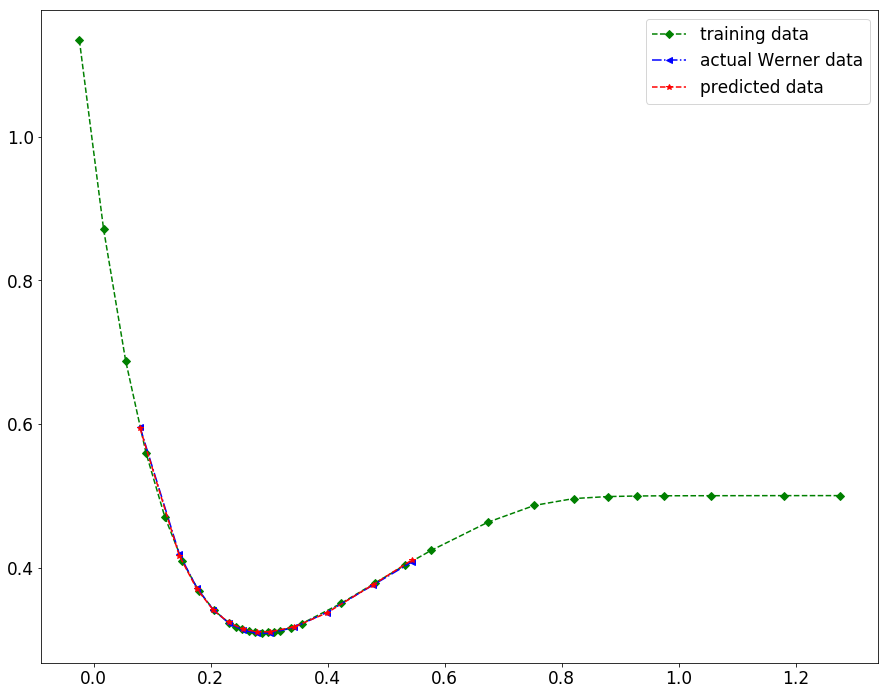

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), p_V_test, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

### Cubic spline

training RMSE = 0.0
testing RMSE = 0.0035166731030738677


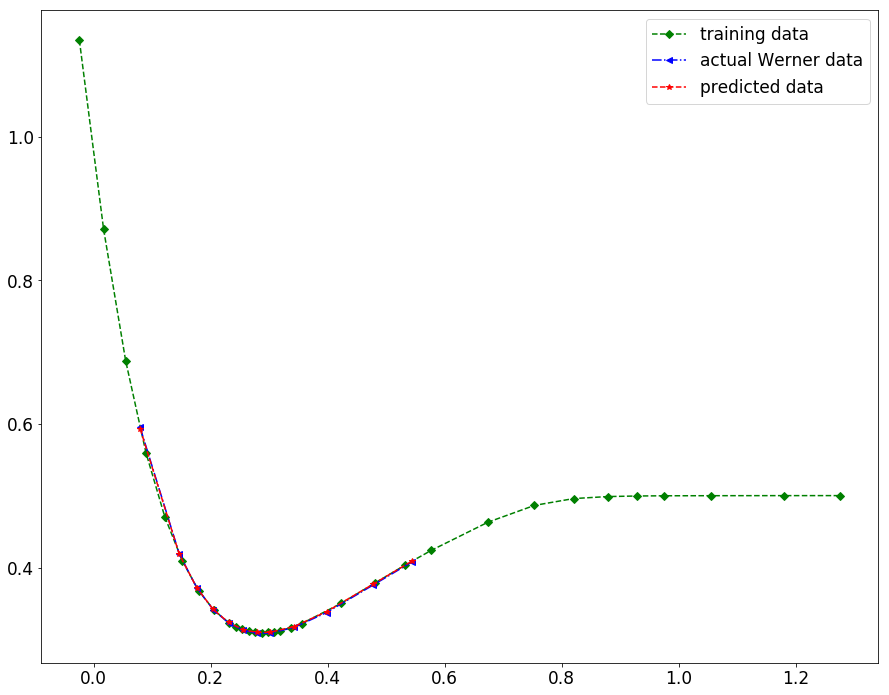

In [29]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
rmse = RMSE(V, V_pred)
print("training RMSE =",rmse)
plt.subplots(figsize=(15, 12))

#predict Werner's V:
V_pred = cs(R_test)
rmse = RMSE(V_test, V_pred)
print("testing RMSE =",rmse)
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

test RMSE = 0.008246436812486388


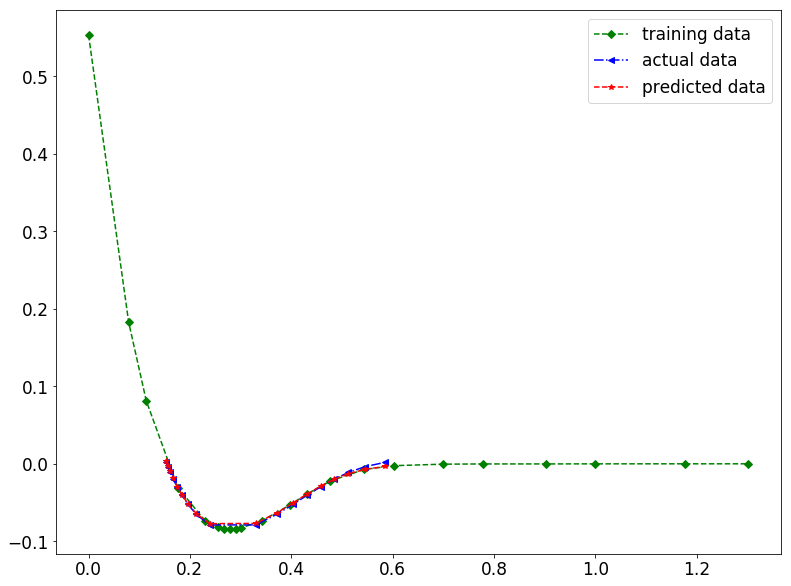

In [38]:
mol = "OH"
qidxs = query_many_vars_indices([mol, "$A^2\Sigma^+$"], ["mol", "state"], list_data)
newidxs = qidxs[1:3]
trainid = newidxs[0]; testid = newidxs[1]
R = list_data[trainid]["R"]; V = list_data[trainid]["V"] # training data
R_test = list_data[testid]["R"]; V_test = list_data[testid]["V"]# test data

cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R_test)
print("test RMSE =", RMSE(V_test, V_pred))

plt.subplots(figsize=(13, 10))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual data", "predicted data"])

### Model 041021

residual =  [6.26993857e-08 3.37775687e-07 1.24525425e-10 1.31078826e-07
 1.00621484e-07 4.83974034e-09 2.49985341e-08 6.62266730e-08
 4.84628518e-08 2.75739942e-08 9.70722669e-09 6.67285361e-10
 2.00686547e-09 1.10201622e-08 2.24702251e-08 3.06994101e-08
 3.28100399e-08 1.62031885e-08 3.94437897e-11 2.14749242e-07
 4.29919692e-11 2.09144001e-07 1.04761908e-07 4.62991031e-09
 5.99056493e-10 9.06920085e-11 4.12289095e-12 5.78492933e-13
 7.82263030e-13 9.26641495e-13 3.90367332e-12 5.51563500e-11]
RMSE =  0.00021390044569069021

`xtol` termination condition is satisfied.
Function evaluations 284, initial cost 3.9022e+36, final cost 1.3901e-04, first-order optimality 4.29e+18.
`xtol` termination condition is satisfied.
RMSE =  0.002947606656112963

RMSE = 0.0

`ftol` termination condition is satisfied.
Function evaluations 307, initial cost 2.0771e+10, final cost 1.1915e-01, first-order optimality 5.25e-02.
`ftol` termination condition is satisfied.
RMSE =  0.08629657007652229


C:\Users\beryl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nZ = (1,1) #reduce the effect of nuclear charge:\nres = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")\nprint(res.message)\nV_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]\nprint("RMSE = ",RMSE(V_pred, V))\nplt.subplots(figsize=(15, 12))\nplt.plot(np.log(R), V, "bD")\nplt.plot(np.log(R), V_pred)\nplt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")\n'

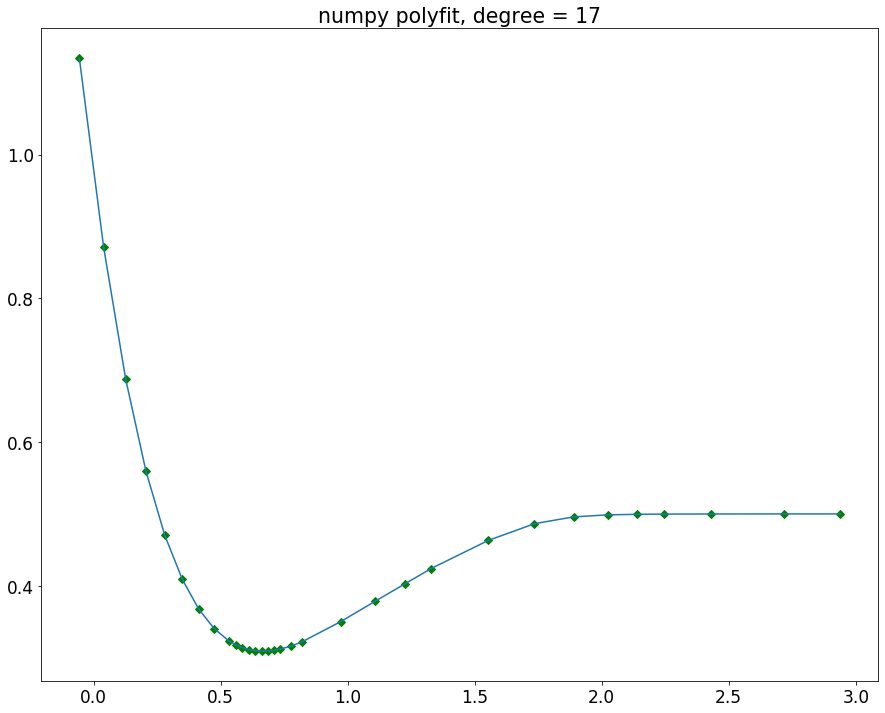

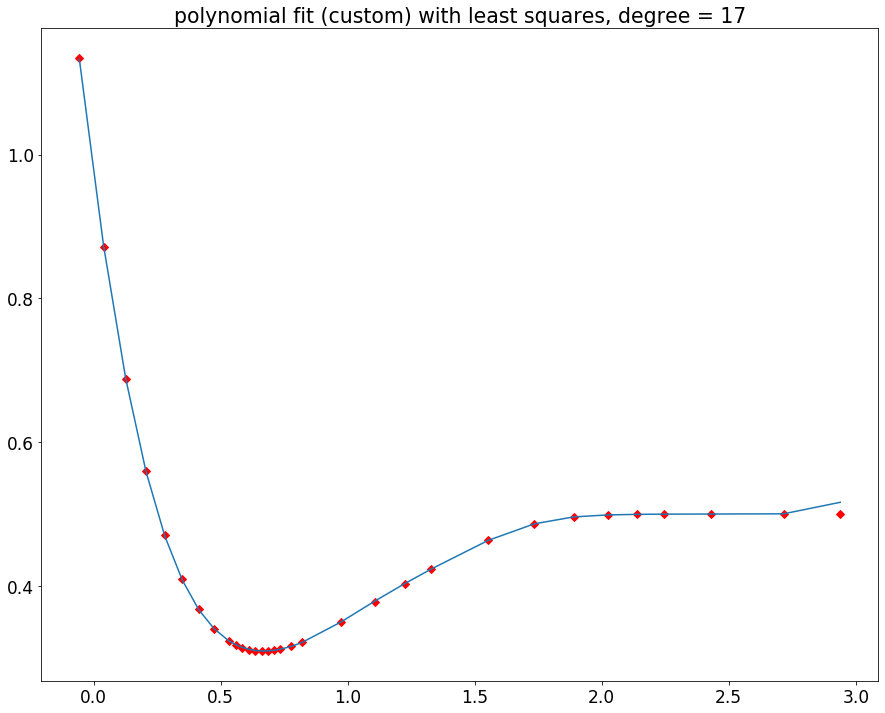

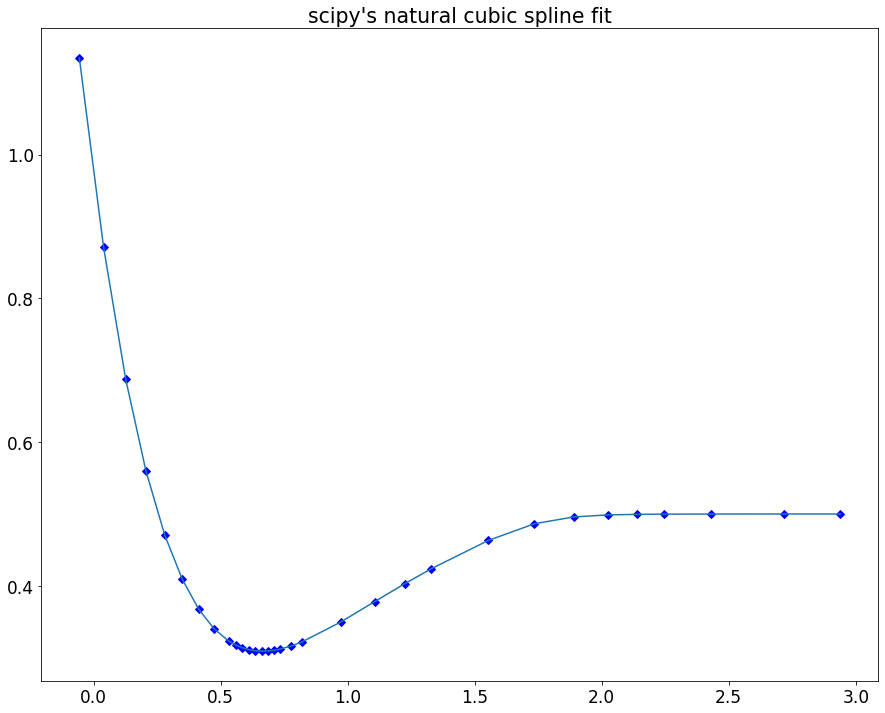

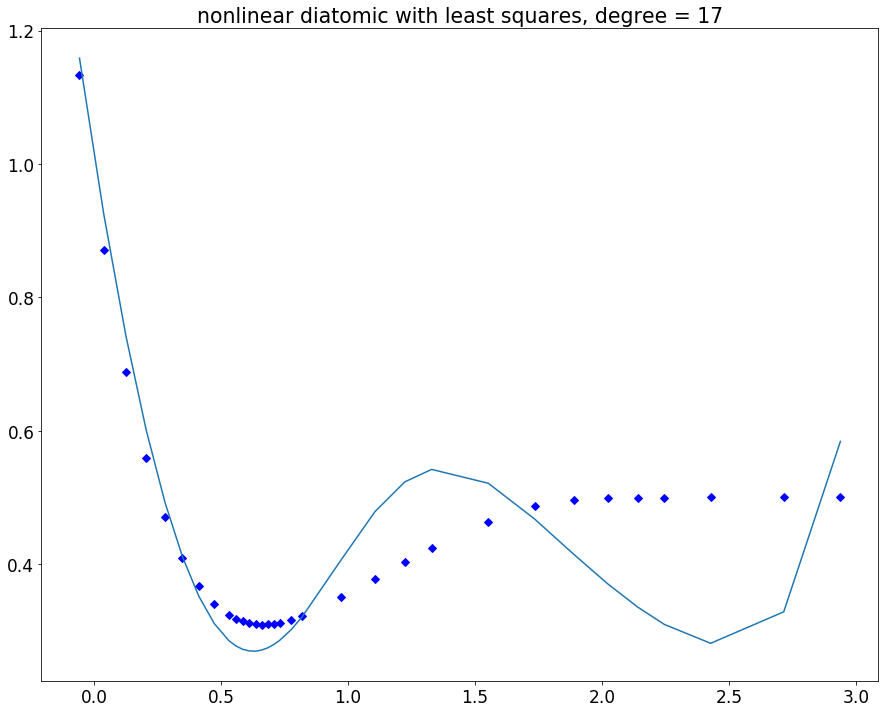

In [58]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 17})

mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#train and test on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]
M = 17
#C0 = np.random.uniform(0, 1, size=(M)) #to avoid division by 0
C0 = np.zeros(M) + 1e-2
Z = (1, 8) #atomic number of atom_1 and atom_2 (permutationally symmetric)
poly_par = {"M":M, "morse":False}


C = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_res(C[::-1], f_monomial_diatomic_pot, R, V, poly_par)
print("residual = ",e) #the residual function is correct
#p = np.poly1d(C)
#V_pred = p(R)
V_pred = [f_monomial_diatomic_pot(r, C[::-1], poly_par["morse"]) for r in R] #doublecheck the residual function
print("RMSE = ",RMSE(V_pred, V)) #the polynomial function is correct
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "gD")
plt.plot(np.log(R), V_pred)
plt.title("numpy polyfit, degree = "+str(M))
print()

#using polynomial fit but manual leastsquares:
#C0 = C[::-1] #look at the correct C
res = least_squares(f_poly_res2, C0, args=(f_monomial_diatomic_pot, R, V, poly_par), verbose=1, method="lm")
print(res.message)
V_pred = np.array([f_monomial_diatomic_pot(r, res.x, poly_par["morse"]) for r in R])
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "rD")
plt.plot(np.log(R), V_pred)
plt.title("polynomial fit (custom) with least squares, degree = "+str(M))
print()

#cubic spline:
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
print("RMSE =", RMSE(V, V_pred))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("scipy's natural cubic spline fit")
print()

#using the 2nd proposed method:
#soln = dfbgn.solve(f_obj_diatomic_pot_lr, C0, args=(f_diatomic_pot_lr, V, R, Z))
#print(soln) #dfbgn fails

res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M))

'''
Z = (1,1) #reduce the effect of nuclear charge:
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")
'''

### Models 111021

In [10]:
# molecule OH+
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

`xtol` termination condition is satisfied.
Function evaluations 3948, initial cost 4.0998e+10, final cost 5.1878e-07, first-order optimality 3.10e-06.
`xtol` termination condition is satisfied.
RMSE =  0.012048278085106202
C after fit [ 9.05630307e-01 -1.28993076e+00 -1.45450972e+00  1.07894759e+00
  1.01893458e-01  4.45684978e-01  7.55404090e-01  8.11020980e-01
  4.95552683e+01  3.47166593e-02  7.47944990e-01  8.37140439e-01
  2.51021962e-02  1.40745821e+00  1.81352849e-02  6.77094385e+00
 -7.19693716e+00  5.97248719e-01  8.07254359e-01]
RMSE =  0.00013761279687157723


Text(0.5,1,'OH+ CHIPR lmfit')

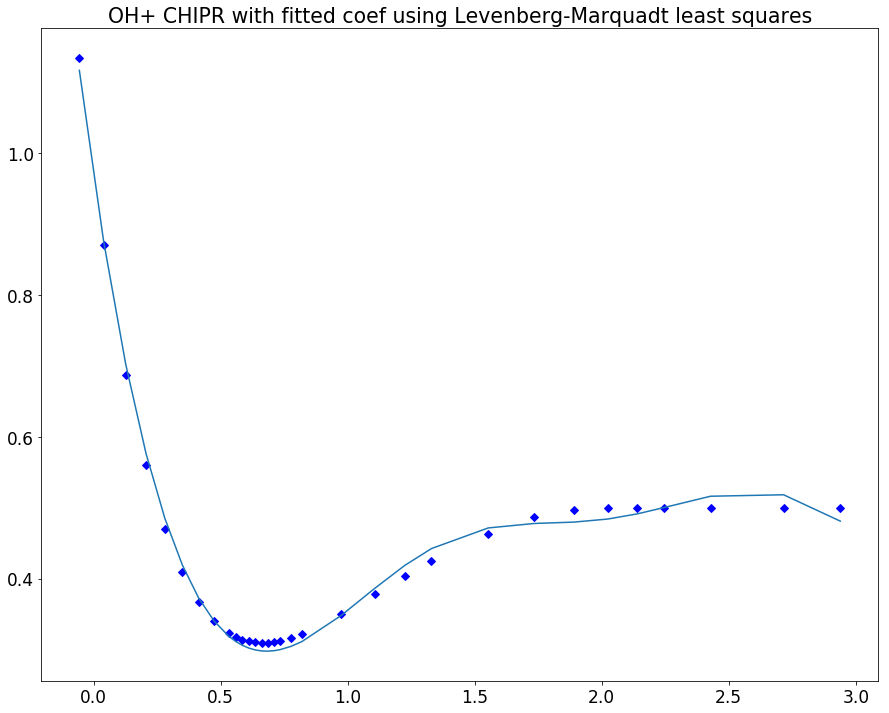

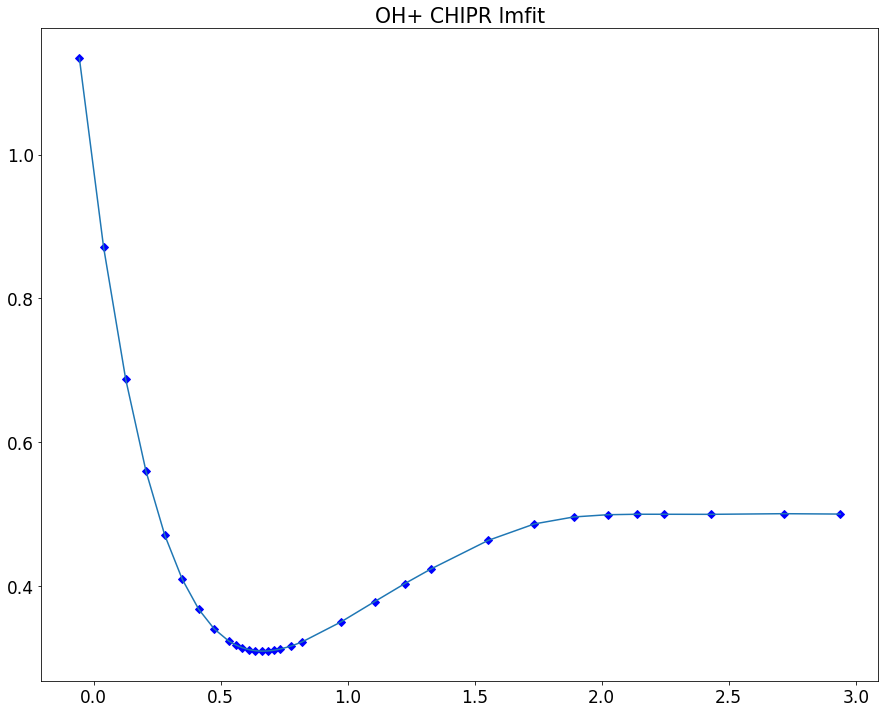

In [47]:
#CHIPR:
'''
C = np.array([8.57082, 0.921,
              -3.56097,  0.238234, 2.40785, 0.656067,
              0.378471, 1.7461, 5.91989, 8.5025,
              0.00683275,
              0.255374, 0.75669, 0.0664867, 0.358579,
              1.90036, 0.952497, 45.2516, 1.36563
             ]) #for chipr, from supp https://pubs.acs.org/doi/suppl/10.1021/acs.jpca.8b12005/suppl_file/jp8b12005_si_001.pdf
V_pred = f_diatomic_chipr_ohplus(C, R)
shift_O = 1313.9*0.00038088
print("RMSE = ",RMSE(V_pred+shift_O, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred+shift_O) #shift by 0.5
plt.title("OH+ CHIPR with Coeff from supp (and shifted by molar ionization energy)")
F = f_obj_diatomic_pot_res(C, f_diatomic_chipr_ohplus, V, R)
'''


##refit using LM LS:
m = M = 4; # default setting from paper
len_C = 3*m + M + 3
Z = 8
C0 = np.random.uniform(0, 1, len_C)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_chipr_ohplus, V, R, Z, M, m), verbose=1, method="lm")
print(res.message)
V_pred = f_diatomic_chipr_ohplus(res.x, R, Z, M, m)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR with fitted coef using Levenberg-Marquadt least squares")

##refit using lmfit:
C0 = np.random.uniform(0, 1, len_C)+1e-9
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_chipr_ohplus, V, R, Z, M, m), method='leastsq')
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_chipr_ohplus(C, R, Z, M, m)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR lmfit")

C after fit [2.48049922e+01 7.08999234e+01 1.23990514e+03 2.55740800e+00
 4.84834053e-01]
RMSE =  0.01799576794236503
C after fit [ 1.00000000e-09 -1.41270504e+07 -6.53574466e-01 -4.13183564e-03
 -1.14400843e-03  1.00000000e-09  0.00000000e+00  1.08967434e+00]
RMSE =  121802704.1343347


Text(0.5,1,'OH+ Deiters-Sadus lmfit')

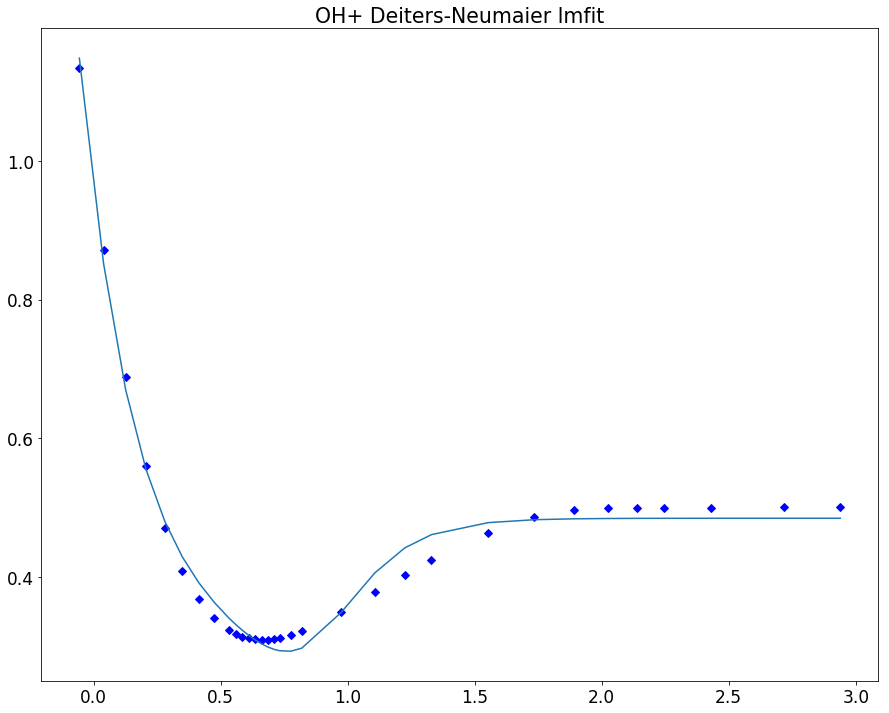

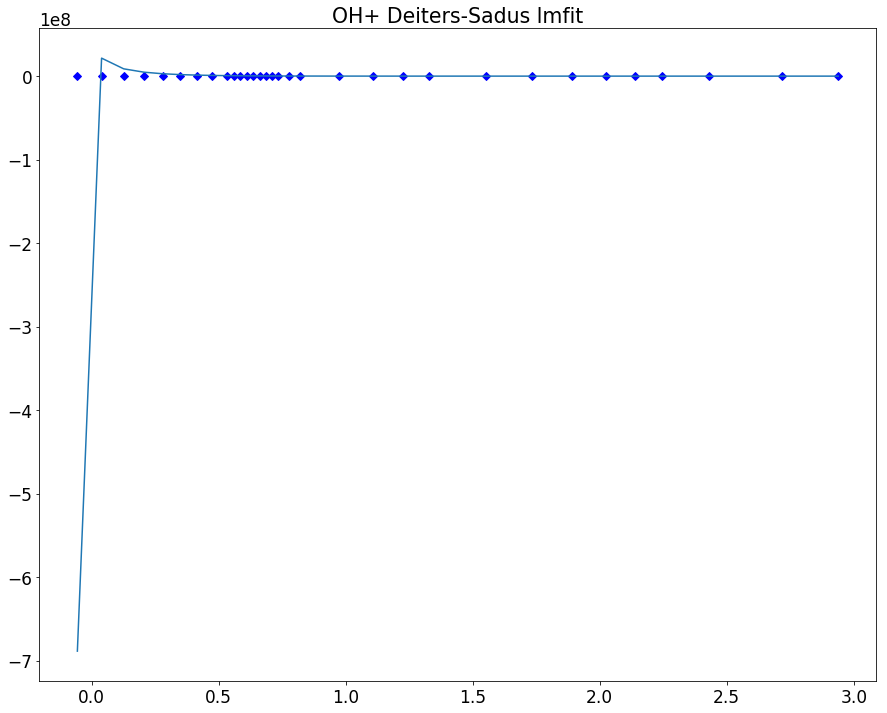

In [14]:
#Deiters-Neumaier:
'''
#from available coeffs (for Argon)
C = [1.639146038e9, 7.075527590e5, 2.726770354e4, 2.503350833] #from table 1 https://pubs-acs-org.uaccess.univie.ac.at/doi/full/10.1021/acs.jced.6b00133#
V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("Deiters-Neumaier OH+, coeffs from table")
'''
##lmfit:
C0 = np.random.uniform(0,1,5) #5 free parameters
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=0, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_dn, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier lmfit")

#Deiters-Sadus:
## initial points, c[1:5] < 0; c[[0, 5]] > 0, c[6] = 0

C0 = np.random.uniform(-1,-1e-9,8) #8 free parameters 
C_params = Parameters()
#for i, c in enumerate(C0):
#    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

C_params.add(name="c0", value=C0[0], min=1e-9, max=np.inf)
for i in range(1, 5):
    C_params.add(name="c"+str(i), value=C0[i], min=-np.inf, max=-1e-9)
C_params.add(name="c5", value=C0[5], min=1e-9, max=np.inf)
C_params.add(name="c6", value=0, vary=False)
C_params.add(name="c7", value=C0[7], min=-np.inf, max=np.inf)
#C_params.add(name="c8", value=C0[8], min=1e-9, max=np.inf)



out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_ds, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Sadus lmfit")

[1.  1.  0.1 0.  0.1 1. ]
[-16.93673305 -15.25557368 -13.12042319 -10.6351705   -8.19432168
  -6.08043975  -4.38111197  -3.07014937  -2.0802592   -1.68309164
  -1.34006118  -1.04387073  -0.78806297  -0.56698945  -0.37575005
  -0.21011877  -0.06646596   0.16688793   0.34414078   0.72891471
   0.87569708   0.93792233   0.96675317   0.99119432   0.9970362
   0.99882117   0.9994699    0.99973815   0.99986069   0.99995327
   0.99999167   0.99999781]
[ 0.94486299  1.03934929  1.13383559  1.22832189  1.32280819  1.41729449
  1.51178079  1.60626709  1.70075339  1.74799654  1.79523969  1.84248284
  1.88972599  1.93696914  1.98421229  2.03145544  2.07869859  2.17318489
  2.26767119  2.64561638  3.02356158  3.40150678  3.77945198  4.72431497
  5.66917797  6.61404096  7.55890395  8.50376695  9.44862994 11.33835593
 15.11780791 18.89725989]
-0.5 2.0


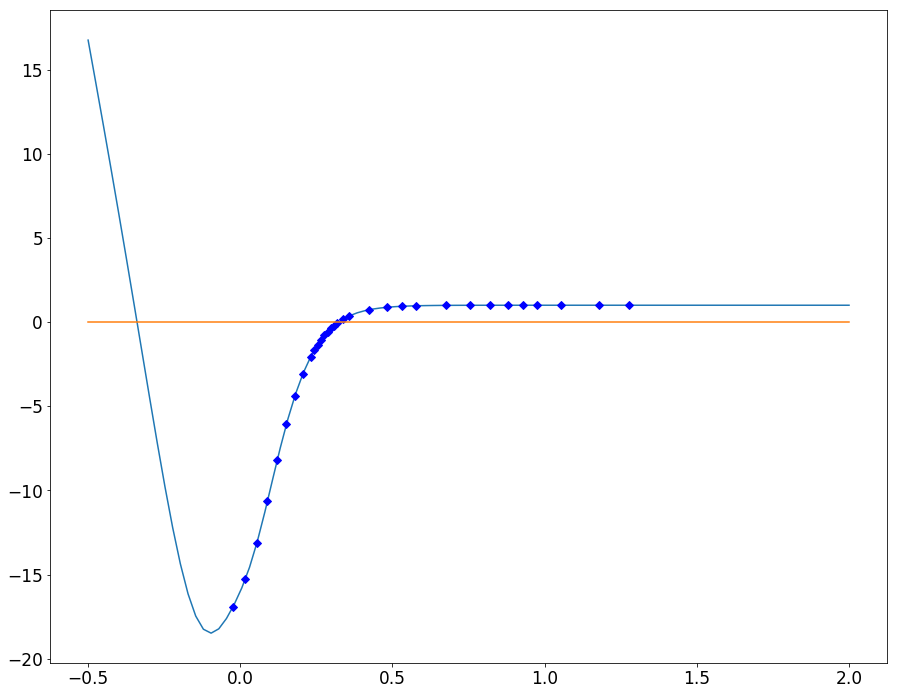

In [304]:
# test print the function:
M = 0.1
C = np.array([1, 1, M, 0, M, 1])
#C = np.zeros(5)
print(C)
ex = np.linspace(-.5, 2, 100)
R_temp = 10**ex
V_temp = f_diatomic_vdw(C, R_temp, 8)
V_pred = f_diatomic_vdw(C, R, 8)

plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R_temp), V_temp)
plt.plot(np.log10(R), V_pred, "bD")
plt.plot([ex[0], ex[-1]], [0,0])
#plt.plot(np.log(R), V_pred)
print(V_pred)
print(R)
print(ex[0], ex[-1])

C after fit [  0.50235353  -1.17188655 -14.77340122  -2.11919494  -0.94912454
   0.15377634  -0.03778822]
RMSE =  0.0013656805061968938


Text(0.5,1,'OH+ 3rd model lmfit')

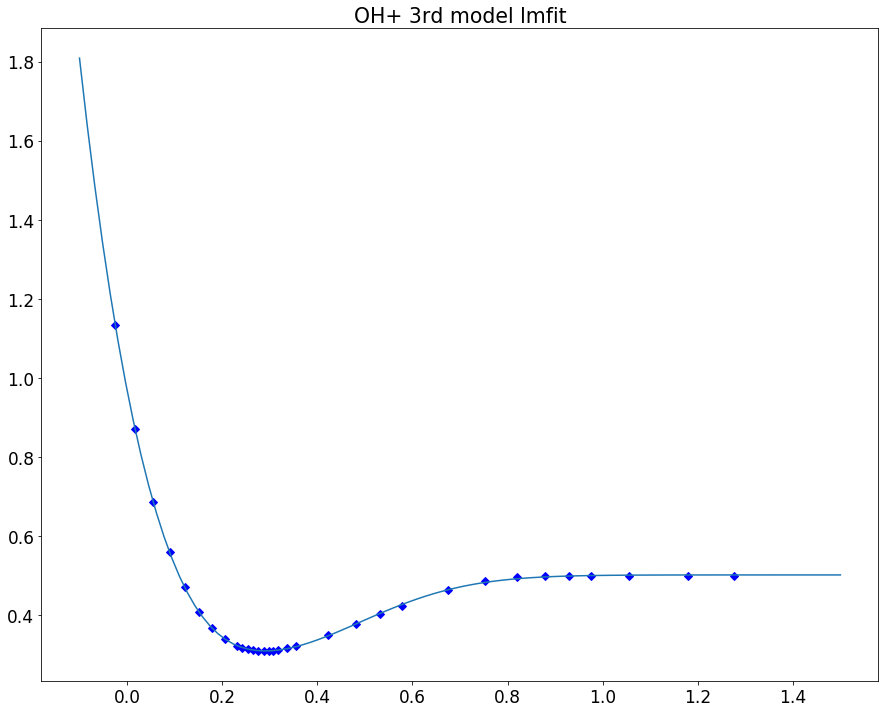

In [15]:
#new proposed model:
'''
C0 = np.zeros(5)
tempC = np.random.uniform(1e-2, 1e9, 2)
C0[0] = tempC[0]; C0[2] = tempC[1]
Z = 8
f_diatomic_vdw(C0, R, Z)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_vdw, V, R, Z), verbose=1)
print(res.message)
V_pred = f_diatomic_dn(res.x, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier with fitted coef using Levenberg-Marquadt least squares")
'''
##lmfit:
C0 = np.random.uniform(0, 1, 7) #7 free parameters
#add params:
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_vdw, V, R, 8), method="leastsq", max_nfev=int(1e4))
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
#C0 -> |C0|, C3->|C3|:
#C[0] = np.abs(C[0])
#C[3] = np.abs(C[3])

print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_vdw(C, R, 8)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
ex = np.linspace(-.1, 1.5, 100)
R_temp = 10**ex
V_temp = f_diatomic_vdw(C, R_temp, 8)
plt.plot(np.log10(R), V, "bD")
#plt.plot(np.log10(R), V_pred)
plt.plot(np.log10(R_temp), V_temp)
plt.title("OH+ 3rd model lmfit")

#### Multiple starts for the optimization

In [109]:
##finding the global optimum by multiple starting points, take the lowest RMSE:
M=10
m = int((2*m-2)/3)
#len_C = 3*(m+1) + M #chipr
len_C = 3*M + 1 #must always be 3M+1 parameters for the ansatz
print("params =",len_C)
#rmse, C = multiple_multistart(int(5), int(2), 1e-5, f_diatomic_chipr_ohplus, V, *(R, 8, M, m), len_C=len_C, mode="default")
rmse, C = multiple_multistart(int(20), int(2), 1e-5, f_diatomic_vdw, V, *(R, 8, M), len_C=len_C, mode="default")

print("rmse = ",rmse)
print(C)
'''
V_pred = f_diatomic_vdw(C, R, 8, m)
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ 3rd model lmfit")
'''

params = 31
0 th round is done
RMSE =  0.0011093139439811884
1 th round is done
RMSE =  0.0011014186499372232
2 th round is done
RMSE =  0.00018473776039032832
3 th round is done
4 th round is done
RMSE =  6.25676885982276e-06
rmse =  6.25676885982276e-06
[ 5.00455556e-01  5.34124006e+00 -8.11559517e+00  3.50686266e+00
  5.73485780e+00  5.38550535e+00  4.41097521e+00  3.46989504e+00
  2.54917688e+00  1.44857831e+00  4.16262633e-01 -1.34727867e+00
 -3.29082343e+00 -3.50435095e+00 -9.21682025e-01  5.11801963e-01
  1.21219718e-01 -6.75975009e-02  8.98809189e-03 -4.05165200e-04
 -9.44835941e+00  1.08888661e+01 -5.74864030e+00 -3.63409959e+00
  5.66186034e+00 -5.30473723e+00  2.19756590e+00 -6.36428165e-01
  1.15618566e-01 -1.02166824e-02  1.94154435e-04]


'\nV_pred = f_diatomic_vdw(C, R, 8, m)\nplt.subplots(figsize=(15, 12))\nplt.plot(np.log(R), V, "bD")\nplt.plot(np.log(R), V_pred)\nplt.title("OH+ 3rd model lmfit")\n'

In [ ]:
#several obtained data from training for OH+ data for the 3rd ansatz

rmse =  0.7608358031159257
[ 0.45202643 -0.56713766 14.99790643 14.21165152 16.94242195]

rmse =  0.3388745479985727
[ 1.40190265  1.6732669   0.85488082 -1.37075425  0.85787211]

rmse =  0.3044378687788408
[ 1.58502333e+00  1.02774471e+02  6.17834991e-01 -3.31775174e-01
  9.75283009e-02]

rmse =  0.29465895741657055
[ 8.19332849e-01  1.00754909e+02  6.16203290e-01 -3.31951898e-01
  9.81530688e-02]


#m-family pot, with m=2:
rmse =  0.0018350440406569792
[ 5.02893115e-01  2.43195189e+02  3.67590116e+02 -1.74032015e+03
  1.24472977e+00 -3.29342438e-02  5.33987052e-02]

In [32]:
rmse =  0.0018350440406569792
C = np.array([ 5.02893115e-01,  2.43195189e+02,  3.67590116e+02, -1.74032015e+03,
  1.24472977e+00, -3.29342438e-02,  5.33987052e-02])
m=2
V_pred = f_diatomic_vdw(C, R, 8, m)
print("RMSE = ",RMSE(V_pred, V))

RMSE =  0.001835044040685022


C after fit [-1.05134424 -2.22507655]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 32
    # variables        = 2
    chi-square         = 3.78443419
    reduced chi-square = 0.12614781
    Akaike info crit   = -64.3148644
    Bayesian info crit = -61.3833926
[[Variables]]
    c0: -1.05134424 +/- 0.53445594 (50.84%) (init = -9.29927e+08)
    c1: -2.22507655 +/- 0.64636791 (29.05%) (init = -4.031011e+08)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c1) =  0.948
RMSE =  0.34389470567675695


Text(0.5,1,'OH+ LJ lmfit')

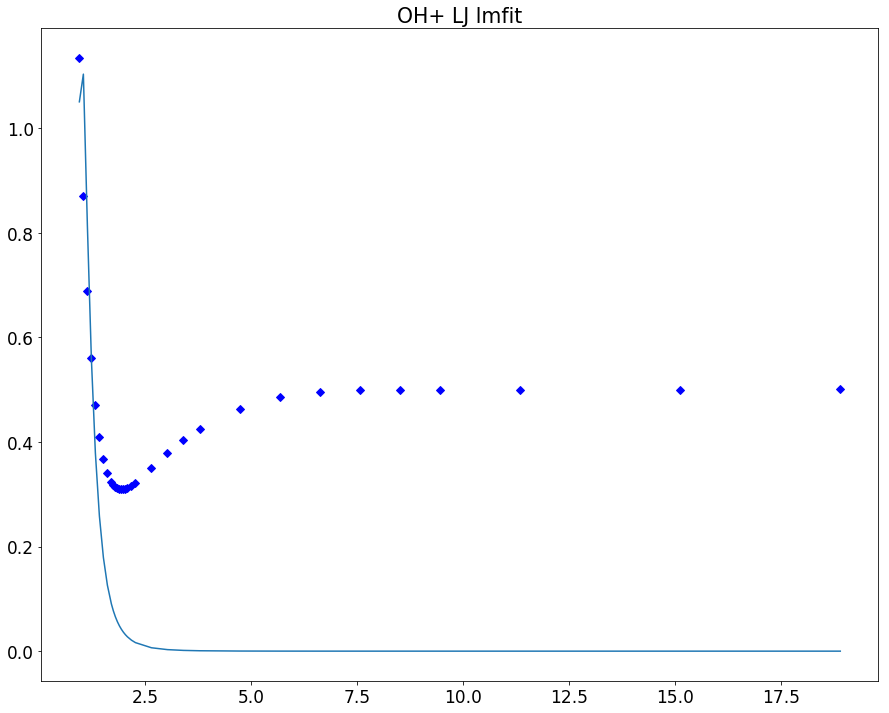

In [221]:
C0 = np.random.uniform(-1e9, 1e9, 2)
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_lj_pot, V, R), method="leastsq")
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_lj_pot(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(R, V, "bD")
plt.plot(R, V_pred)
plt.title("OH+ LJ lmfit")

### Model 141021

#### Multiple data tests at once

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


C after fit [  0.6636017    0.38751827 -26.35529515  -2.38827907   6.39510433
  20.76354389   3.4992733    2.67131316  19.00970747  16.08588802
  -6.85902634  12.74758881  -0.17147783  11.47370008   6.83205733
  14.32356195   9.09752304  16.18753132   0.2808033 ]
CHIPR RMSE =  0.0019885582566109244
C after fit [-0.86400645 -1.88600278  0.90744564  0.36128171]
Deiters-Neumaier RMSE =  0.010588309082711977
C after fit [-1.45549563e+00  4.39739089e+00 -7.99506708e+02 -5.15916708e-02
  7.95725030e+02 -2.64881032e+00 -1.15815470e+00]
Deiters-Sadus RMSE =  0.006996300750155395
C after fit [ 0.02468145  0.31216736  0.95290725 -1.77367869  0.03852885]
3rd ansatz RMSE =  0.3967557594802528


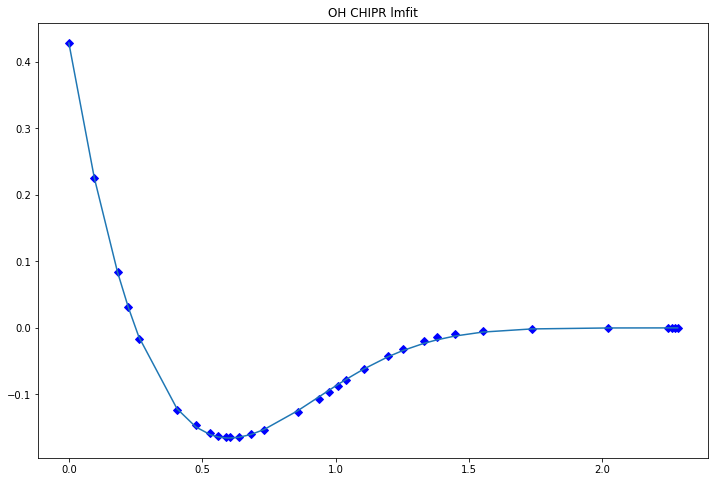

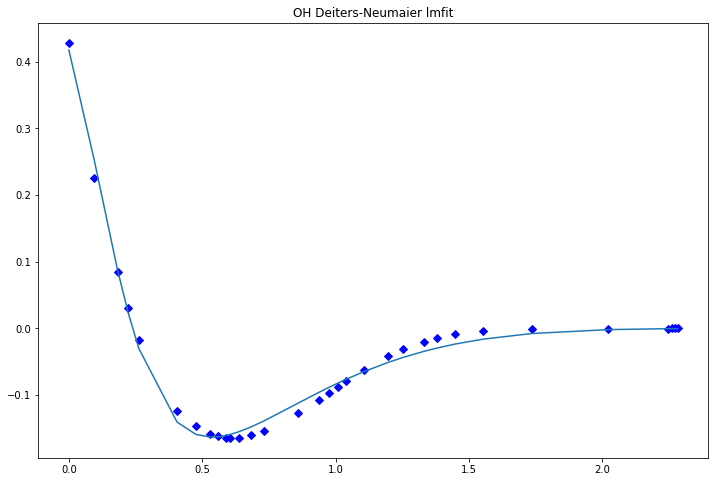

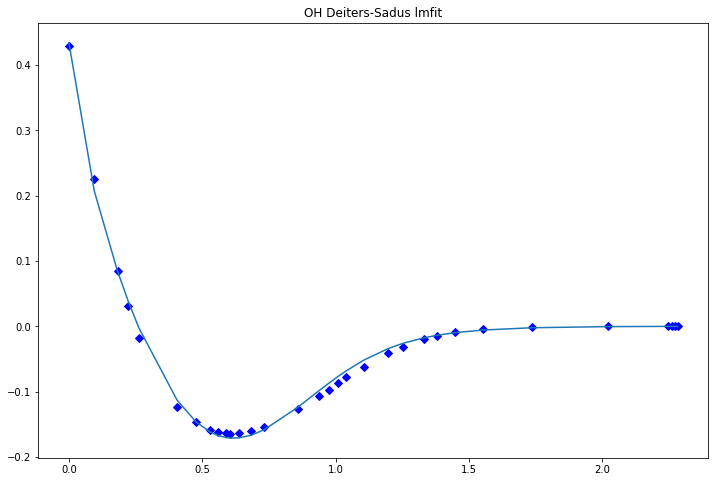

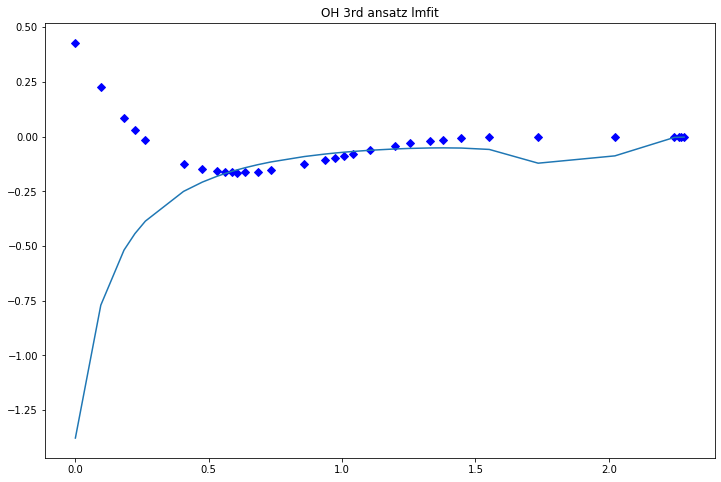

In [100]:
#test available models on each data (using lmfit now):
#OH $X^2\Pi$ Nemukhin and Grigorenko(1997) 32

'''
mols = ["OH", "O2+", "O2", "H2", "H2+"]
states = ["$X^2\Pi$", "$X^2\Pi_g$", "$^3\Sigma_g^-$", "ground", "$X^2\Sigma_g^+ 1s \sigma_g$"]
authors = ["Nemukhin and Grigorenko(1997)", "Xavier(2018)", "Bytautas(2010)", "H2 Kolos(1965)", "Sharp(1971)"]
for k in range(len(mols)):
    #queries:
    mol = mols[k]; state = states[k]; author = authors[k]
    idx = query_many_vars_indices([mol, state, author], ["mol","state","author"], list_data)
    R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]
'''

mol = "OH"
idx = query_many_vars_indices([mol,"$X^2\Pi$","Nemukhin and Grigorenko(1997)"], ["mol","state","author"], list_data)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                          np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
#optimize:
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[35, 36, 37]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-4.08936932e-01  1.93136672e-02 -4.34735155e-02  1.32795736e-01
 -1.64454577e-01  4.35953428e+00  3.69377061e-01  1.09525728e+00
 -1.89119470e+00  1.69549689e+00  1.64564411e+00  1.04481758e+00
 -8.54875319e-01  9.20142510e-01  7.72990090e-01  2.10240820e+00
 -1.45354063e-03  1.15823238e+00  4.91680204e+00]
CHIPR RMSE =  0.000348618372506354
C after fit [ 0.93047244 -0.65198518 -7.96545951 -0.03908842]
Deiters-Neumaier RMSE =  0.2782822804644427
C after fit [ 1.68792213e+01  1.63412589e+00 -6.57671353e+01  1.21864723e+00
 -2.05849304e+02 -4.46872411e+01 -9.95192912e-03]
Deiters-Sadus RMSE =  0.3089238344811664
C after fit [  4.8188279    3.09265446   7.36172655  13.30504416 -88.85338835]
3rd ansatz RMSE =  0.43257627899128076


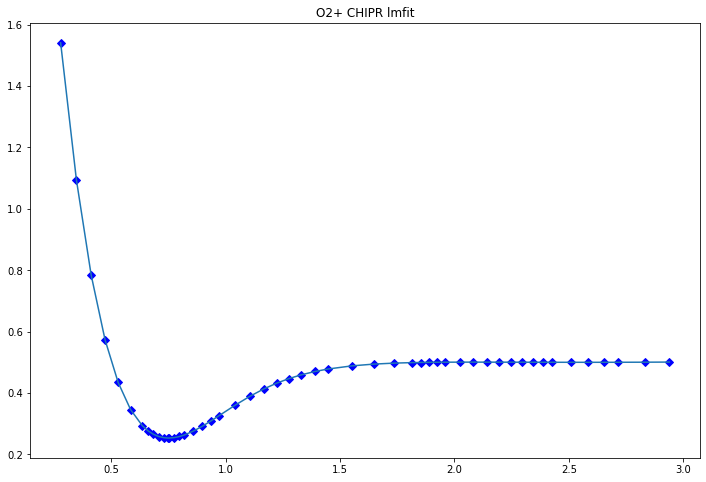

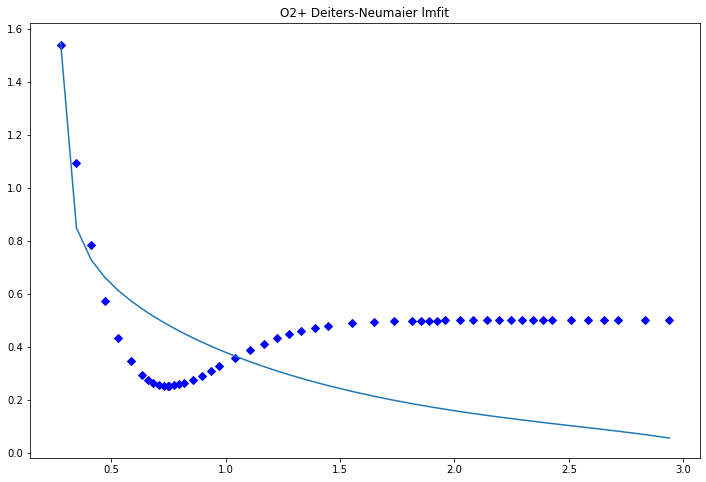

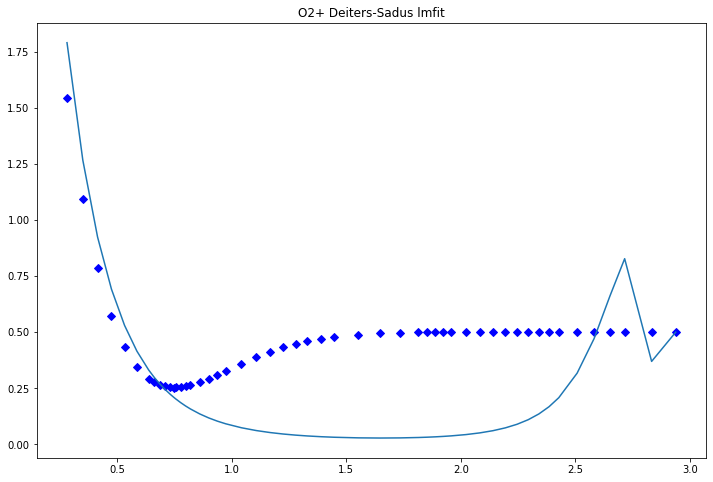

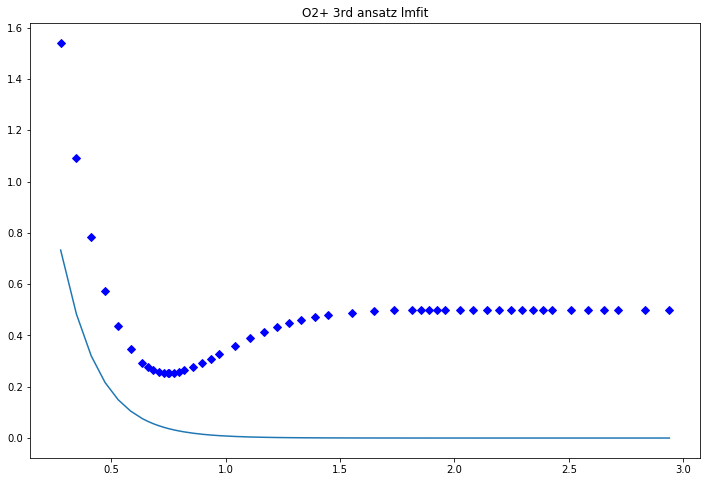

In [101]:
#O2+ $X^2\Pi_g$ Xavier(2018) 51
mol = "O2+"
idx = query_many_vars_indices([mol,"$X^2\Pi_g$","Xavier(2018)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)
    
    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[17]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-1.72454016  1.60887705  1.07524731 -2.07245441  5.44918873  0.63060324
 -1.09559607  0.56052398 -0.12910523  0.01324929  1.51497948 -0.89238472
  0.76698878  0.19709672  1.42343164  0.52877561  0.31603624  2.74265084
  1.14219318]
CHIPR RMSE =  0.00096766880526363
C after fit [ 2.61837712e+03  2.06542100e+05 -1.33389666e+02  4.95274372e-01]
Deiters-Neumaier RMSE =  0.007602799409312086
C after fit [-0.50719184 -0.37253752 -0.99191575 -0.9765786   0.27970902 -1.25640081
 -0.06093759]
Deiters-Sadus RMSE =  0.12174280104408788
C after fit [ 0.32189562  0.08826392  0.08144192  0.78858093 -0.00156081]
3rd ansatz RMSE =  0.10296348258343929


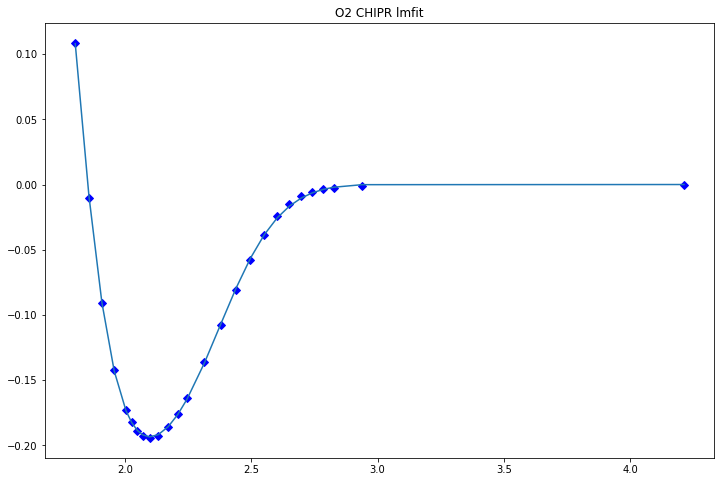

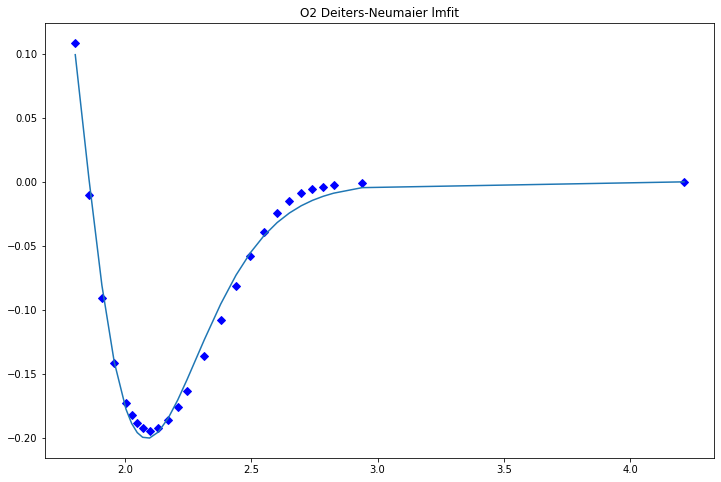

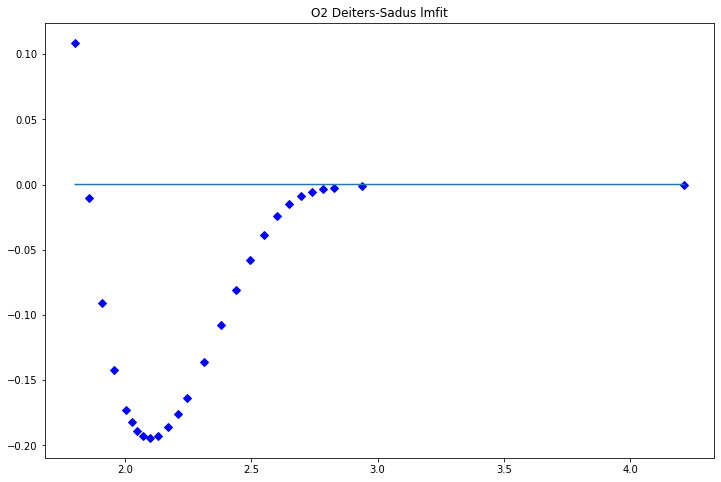

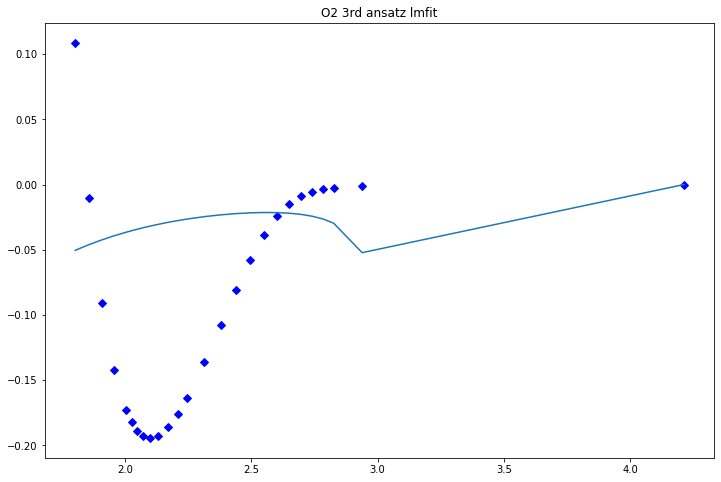

In [102]:
#O2 $^3\Sigma_g^-$ Bytautas(2010) 26
mol = "O2"
idx = query_many_vars_indices([mol,"$^3\Sigma_g^-$","Bytautas(2010)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")


[20]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [ 0.7470348   1.91457572 -0.38002268  0.44483806  0.00799644 -0.08843682
 -1.6997957  -3.5817279   2.05027925  1.63592121  0.47668814  0.3902616
  0.24042801  2.17051513  2.38855204  2.73202377  5.45503124  1.63228227
  0.45253894]
CHIPR RMSE =  0.00013907860272050865
C after fit [  1.69866893  17.9586175  185.87253493   2.86247496]
Deiters-Neumaier RMSE =  0.019023479533293766
C after fit [ 9.17901584e-01  2.01163322e+00  5.56397462e+01 -2.25459822e-02
 -5.90632592e+01  9.84255579e-02 -4.15946999e-01]
Deiters-Sadus RMSE =  0.0014916684664609402
C after fit [ 1.53678657e-05  6.85846266e-04  2.94014835e+00 -1.31516939e-02
  1.37198422e-01]
3rd ansatz RMSE =  0.13563202996872506


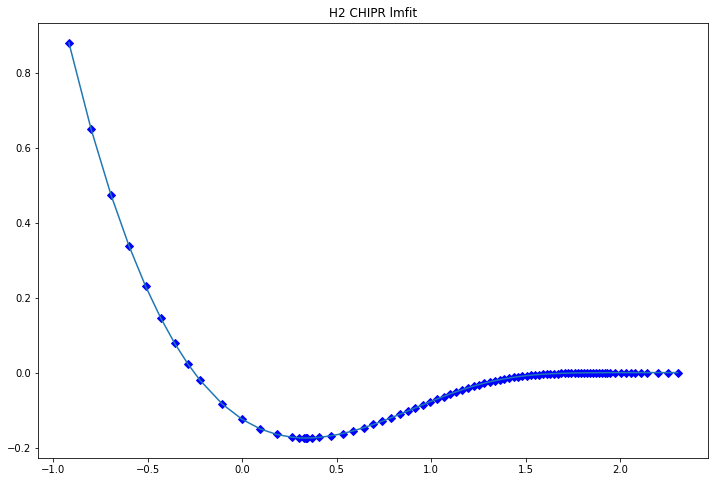

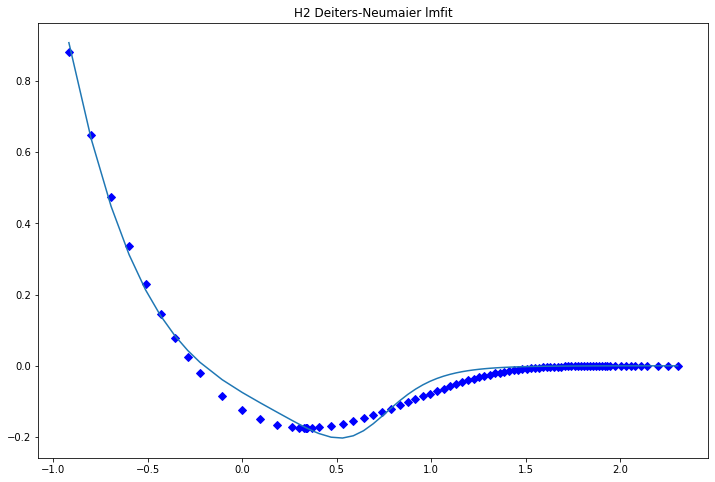

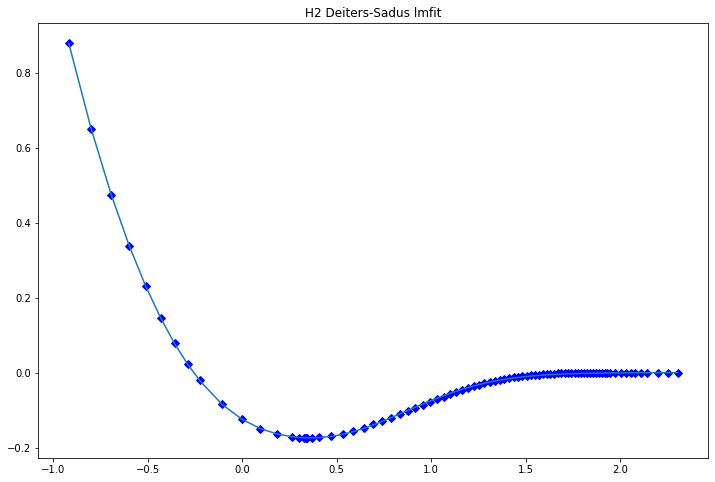

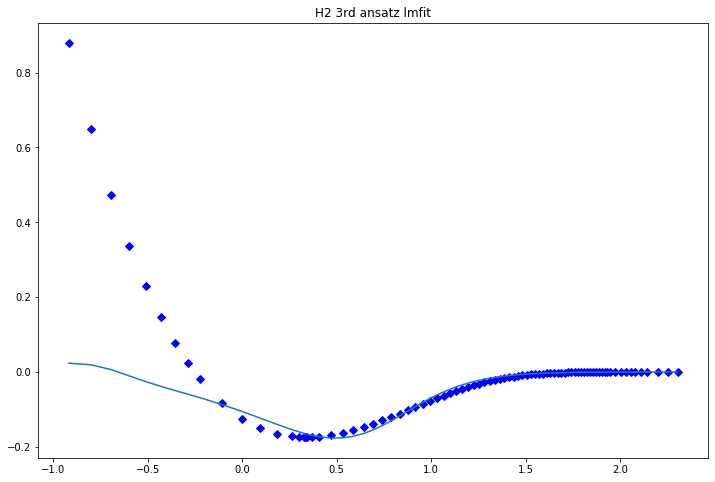

In [107]:
#H2 ground H2 Kolos(1965) 87
mol = "H2"
idx = query_many_vars_indices([mol,"ground","H2 Kolos(1965)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[28]
[ 0.25001075  0.5000215   0.75003224  1.00004299  1.25005374  1.50006449
  1.74988627  1.99989701  2.24990776  2.49991851  2.74992926  2.99994001
  3.4999615   3.999983    4.5000045   4.99983702  5.49985852  5.99988001
  6.49990151  6.99992301  7.99977703  8.99982002  9.99986301 11.99976003
 13.99965704 15.99974303 17.99964004 19.99953706]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-0.04458781  0.90135017  0.55435426 -0.58191494 -0.81131965  0.648264
 -0.77791062 -0.26324257 -0.11221761 -0.02561277  0.0769068   3.12295619
  0.68313179  3.46974508  1.67406674  0.2833368  -0.08941719  0.25498657
  0.0690522 ]
CHIPR RMSE =  0.00039868909605815083
C after fit [ 0.82047973  0.52863891  0.51402926 -0.03901942]
Deiters-Neumaier RMSE =  0.2755323193200035
C after fit [ 9.43097028e+03  1.90067119e+02  2.48230814e+02 -4.05845731e-03
 -2.46557328e+02 -4.10832463e-02 -9.20535298e+02]
Deiters-Sadus RMSE =  0.39107723930214616
C after fit [ 1.25462782e-03  1.35086776e-02 -1.25800471e+03  5.14651336e+03
 -4.67461724e+02]
3rd ansatz RMSE =  0.837677181748727


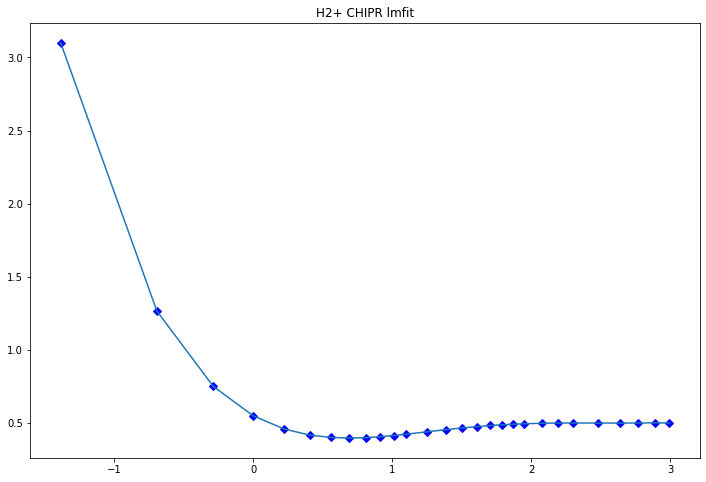

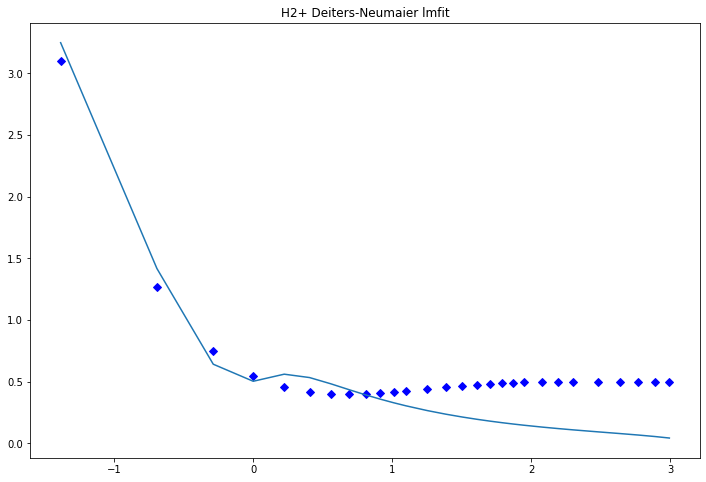

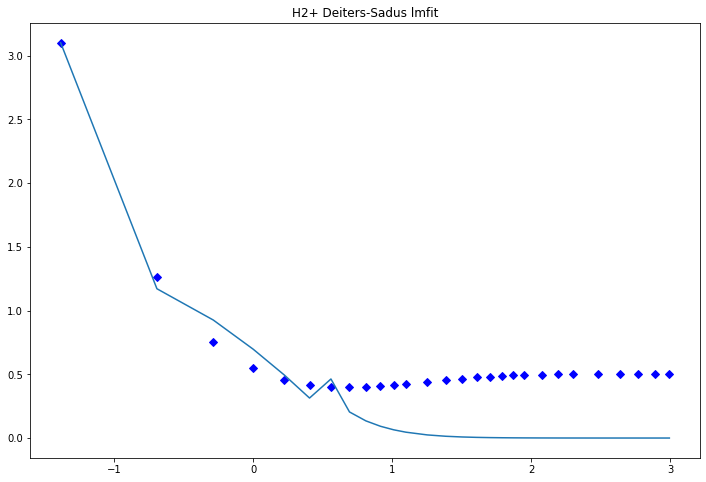

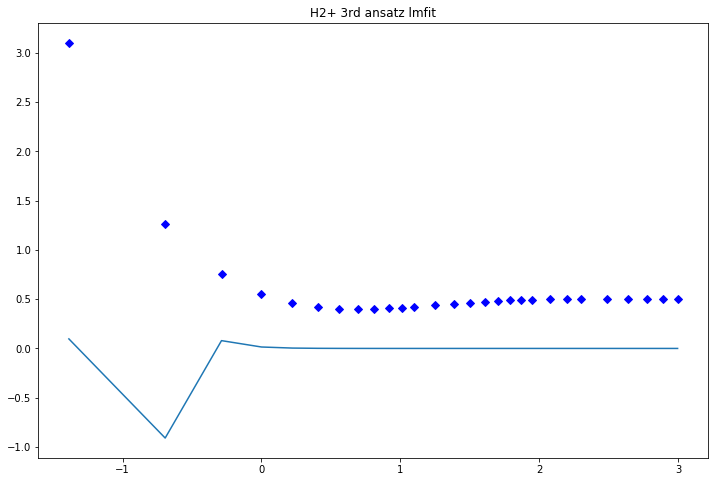

In [116]:
#H2+ $X^2\Sigma_g^+ 1s \sigma_g$ Sharp(1971) 29
mol = "H2+"
idx = query_many_vars_indices([mol,"$X^2\Sigma_g^+ 1s \sigma_g$","Sharp(1971)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"][:len(list_data[idx[0]]["R"])-1]; V = list_data[idx[0]]["V"][:len(list_data[idx[0]]["R"])-1] #slice last due to infinite
print(R)
##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

In [14]:
#SNOBFIT example
from skquant.opt import minimize

 # some interesting objective function to minimize
def objective_function(x):
    fv = np.inner(x, x)
    fv *= 1 + 0.1*np.sin(10*(x[0]+x[1]))
    return np.random.normal(fv, 0.01)

# create a numpy array of bounds, one (low, high) for each parameter
bounds = np.array([[-1, 1], [-1, 1]], dtype=float)

# budget (number of calls, assuming 1 count per call)
budget = 40

# initial values for all parameters
x0 = np.array([0.5, 0.5])

# method can be ImFil, SnobFit, Orbit, NOMAD, or Bobyqa
result, history = \
    minimize(objective_function, x0, bounds, budget, method='SnobFit')

print(result, history)

Optimal value: -0.00488087, at parameters: [ 0.00704 -0.00702] [[ 4.75577306e-01  5.00000000e-01  5.00000000e-01]
 [ 1.79396240e+00 -9.92560000e-01 -9.56420000e-01]
 [ 1.75856896e+00  9.37240000e-01 -9.94180000e-01]
 [ 1.66987607e+00 -9.96200000e-01  9.09340000e-01]
 [ 2.24973792e-01 -6.78000000e-03 -4.61920000e-01]
 [ 6.66081890e-01 -8.37260000e-01 -3.78400000e-02]
 [ 1.12167798e+00 -1.60740000e-01  9.98200000e-01]
 [ 1.07475569e+00  9.76480000e-01 -1.76960000e-01]
 [ 8.97612888e-02 -1.88160000e-01  2.35260000e-01]
 [ 2.10983090e+00  9.80020000e-01  9.97020000e-01]
 [ 1.00833329e+00 -3.50720000e-01 -9.87260000e-01]
 [-4.88086958e-03  7.04000000e-03 -7.02000000e-03]
 [ 8.27887094e-02  2.55860000e-01  1.07660000e-01]
 [ 2.03336312e-01 -4.45180000e-01  3.98200000e-02]
 [ 2.81050929e-01  2.31560000e-01 -4.89300000e-01]
 [ 8.97710435e-02 -3.14000000e-02  2.68140000e-01]
 [ 2.10714998e-01  2.92200000e-02  4.91880000e-01]
 [ 6.37884227e-01  6.11540000e-01 -4.43060000e-01]
 [ 1.61110054e-01 -

### Models 191021

#### CHIPR vs Diatomic ansatz performance evaluations (RMSE and time) for the (union of (ideally, currently only pick one)) OH+ dataset

In [9]:
import pandas as pd
import datetime

In [65]:
'''
performance evaluation per dataset contains:
"mol": molecule data name
"F": the functions list
"F_names": the name of the functions
"rmse": list of rmse 
"time": list of time evaluation,
"C_best": list of 1D array of best coefficients found,
"M": polynomial degree
"num_params": the number of parameters

by varying the free parameters:
CHIPR: 3(m+1) + M 
diatomic ansatz: 3M+1
M is common parameter, hence it is used as the reference,
m = 2M-2/3, where 2M-2%3 = 0
'''
Fs = [f_diatomic_vdw, f_diatomic_chipr_ohplus]
F_names = ["ansatz", "CHIPR"]

loop = int(1e4); n = 20; # # of loops per run and evaluation runs
restarts = int(20); powers = int(5); # number of optimization restarts and powers for random number generations
delta = 1e-5 #error tolerance to stop iterations

#physical params:
Z = 8

data = {}
data["num_params"] = []
data["eval_loop"] = loop; data["eval_run"] = n;
data["opt_restart"] = restarts; data["opt_power"] = powers; data["opt_delta"] = delta
data["chipr_t"] = []; data["chipr_acc"] = []; data["chipr_C"] = []
data["ansatz_t"] = []; data["ansatz_acc"] = []; data["ansatz_C"] = []
data["degree"] = []

max_deg = 30 #maximum polynomial degree
init_time = time.time() #timer
for M in range(4, max_deg):
    if (2*M - 2)%3 == 0: # must satisfy this
        m = int((2*M - 2)/3)
        ansatz_par = 3*M+1
        #chipr_par = 3*(m+1)+M;
        print("===========================")
        print("M = ",M, ", m (chipr) =",m)
        print("parameters = ",ansatz_par)
        
        #Time evaluation:
        print(">>> Time evaluation:")
        args = [(R,Z,M), (R,Z,M,m)] 
        times_array = np.zeros(len(Fs))
        len_C = ansatz_par #coef length, min(len) = 3M+1
        for i in range(n):
            times_array += np.array(evaluate_efficiency(Fs, loop, args, len_C))
        mean_t = times_array/n
        print("evaluation on",loop,"runs")
        print("functions",F_names)
        print("running times averaged over",n,"runs",mean_t)
        
        #Accuracy evaluation:
        print(">>> Accuracy evaluation:")
        rmses = []; Cs = []
        for i, f in enumerate(Fs):
            rmse, C = multiple_multistart(restarts, powers, delta, f, V, *args[i], len_C=len_C, mode="default")
            rmses.append(rmse)
            Cs.append(C)
            print("rmse = ",rmse)
            
        #append to data:
        data["num_params"].append(len_C); data["degree"].append(M)
        data["ansatz_t"].append(mean_t[0]); data["chipr_t"].append(mean_t[1])
        data["ansatz_acc"].append(rmses[0]); data["chipr_acc"].append(rmses[1])
        data["ansatz_C"].append(Cs[0]); data["chipr_C"].append(Cs[1])

end_time = time.time() #timer
elasped = end_time-init_time
data["simulation_time"] = elasped
print("elapsed time =",elapsed,"s")
print(data)
#write to pandas, then to file:
df = pd.DataFrame.from_dict(data)
df.to_pickle("result/performance_"+datetime.datetime.now().strftime('%d%m%Y')+".pkl")



M =  4 , m (chipr) = 2
parameters =  13
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.32742152 0.42166713]
>>> Accuracy evaluation:


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

0 th round is done
RMSE =  0.001661180986297057


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

1 th round is done
RMSE =  0.0008338502725512571


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

2 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

3 th round is done
RMSE =  0.0007154904111667688


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

4 th round is done
RMSE =  0.0001508889811805951


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

5 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

6 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

7 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

8 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

9 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

10 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

11 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

12 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

13 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

14 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

15 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

16 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

17 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

18 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

19 th round is done
rmse =  0.0001508889811805951
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:8

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide 

0 th round is done
RMSE =  0.001735592375236942


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarn

1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


2 th round is done
RMSE =  0.0002319806075315468


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarn

3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


5 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: divide by zero encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/li

6 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

7 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: divide by zero encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/us

ValueError!!, resetting C
ValueError!!, resetting C
8 th round is done


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
9 th round is done
RMSE =  0.00022625973765300357


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance(

ValueError!!, resetting C
ValueError!!, resetting C
10 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
11 th round is done
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtr

12 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/p

ValueError!!, resetting C
14 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarn

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: divide by zero encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


16 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
17 th round is done


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipy

18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
19 th round is done
rmse =  0.00022625973765300357
M =  7 , m (chipr) = 4
parameters =  22
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.43275269 0.66156758]
>>> Accuracy evaluation:


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

0 th round is done
RMSE =  0.0007543487435692367


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

1 th round is done
RMSE =  0.00035898095516853737


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

2 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

3 th round is done
RMSE =  0.0001303660990984586


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

4 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

5 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

6 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

7 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

8 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

9 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

10 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

11 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

12 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

13 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

14 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

15 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

16 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

17 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

18 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

19 th round is done
rmse =  0.0001303660990984586
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

0 th round is done
RMSE =  0.00015319184239598755
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar,

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


1 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

2 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyker

4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ip

5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encou

6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stde

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


7 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


9 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r)

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtr

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


15 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


16 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

17 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr

18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: divide by zero encountered in double_scalars
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


19 th round is done
rmse =  0.00015319184239598755
M =  10 , m (chipr) = 6
parameters =  31
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.57539644 0.94537067]
>>> Accuracy evaluation:


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

0 th round is done
RMSE =  0.0009179762167016026


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

1 th round is done
RMSE =  0.0007707878063270999


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

2 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

3 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

4 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

5 th round is done
RMSE =  4.7901456982197154e-05


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

6 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

7 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

8 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

9 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

10 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

11 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

12 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

13 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

14 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

15 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

16 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

17 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

18 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

19 th round is done
rmse =  4.7901456982197154e-05
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in mul

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

0 th round is done
RMSE =  0.00029408295690909616
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


2 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/bari

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).s

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.p

7 th round is done
RMSE =  0.00022337594088012275
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/us

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribow

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, 

13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-pac

15 th round is done
RMSE =  0.0001901953777318051
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

16 th round is done
RMSE =  0.00013840478433079157
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in do

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarni

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance(

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/p

18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: inval

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


19 th round is done
rmse =  0.00013840478433079157
M =  13 , m (chipr) = 8
parameters =  40
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.71285398 1.22735827]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0007722976695309675
1 th round is done
2 th round is done
3 th round is done
RMSE =  0.0006534166272282887
4 th round is done
5 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


6 th round is done
7 th round is done
RMSE =  0.0002964227033191345
8 th round is done
RMSE =  0.00013240293474877914
9 th round is done
10 th round is done
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
18 th round is done
19 th round is done
rmse =  0.00013240293474877914
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as ap

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
0 th round is done
RMSE =  0.0007792860928449159
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optim

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
2 th round is done
RMSE =  0.0002380003242921211
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


3 th round is done
RMSE =  0.00019965203235915112
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountere

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarn

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
4 th round is done
RMSE =  0.0001990172677797067
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: Runtime

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyker

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-pa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/d

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
6 th round is done
RMSE =  0.0001857266064710476
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packag

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
7 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Runti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/li

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: R

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linese

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  fro

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py

11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Run

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: inv

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow enco

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipyk

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(ph

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykerne

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
16 th round is done


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
19 th round is done
rmse =  0.0001857266064710476
M =  16 , m (chipr) = 10
parameters =  49
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.84699967 1.5010235 ]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0003867081479654238
1 th round is done
2 th round is done
3 th round is done
4 th round is done
5 th round is done
RMSE =  0.00016041494695259194
6 th round is done
7 th round is done
RMSE =  0.0001509974713582992
8 th round is done
9 th round is done
10 th round is done
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
18 th round is done
19 th round is done
rmse =  0.0001509974713582992
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value enco

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipyker

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: Runtime

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/li

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
0 th round is done
RMSE =  0.00031699262832653315
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: R

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in mul

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: R

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipyk

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
2 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_d

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid v

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid v

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/d

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in mul

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


7 th round is done
RMSE =  0.00024496842472480776
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_d

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
8 th round is done
RMSE =  0.00011220834153193748
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_ins

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in t

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtime

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow enco

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dis

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ov

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarn

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add



ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipyke

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multi

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipyk

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykerne

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Runti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero enco

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


16 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 -

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Ru

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/u

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as ap

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
19 th round is done
rmse =  0.00011220834153193748
M =  19 , m (chipr) = 12
parameters =  58
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [0.99672292 1.78196021]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0015788763872948111
1 th round is done
RMSE =  0.0011064015843207228
2 th round is done
RMSE =  0.0007608858146288367
3 th round is done
RMSE =  0.0007330187796028983
4 th round is done
RMSE =  0.0002617904819347396
5 th round is done
6 th round is done
7 th round is done
8 th round is done
9 th round is done
10 th round is done
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
RMSE =  0.00015297823039644998
18 th round is done
19 th round is done
rmse =  0.000152978

/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 -

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - o

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launc

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/us

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: ov

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-pa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scal

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add



ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


0 th round is done
RMSE =  0.0007238513318868618
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-pac

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
1 th round is done
RMSE =  0.0006283867552190135
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
2 th round is done
RMSE =  0.0002373887349776453
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Runti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divi

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: ov

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/pyt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 -

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multi

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply



ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in tr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).s

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/si

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
7 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linese

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instan

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipyk

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_div

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encoun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in mul

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Runtime

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dis

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: di

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_d

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multi

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encounter

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as ap

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow enco

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelap

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
11 th round is done
RMSE =  0.0001794862372111615
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykerne

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: div

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykern

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encoun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 -

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipyker

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in pow

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarni

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-package

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(ph

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power



ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_ph

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarni

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: R

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWar

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 -

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encount

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_l

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launc


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
16 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtime

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp



ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scal

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: R

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
19 th round is done
rmse =  0.0001794862372111615
M =  22 , m (chipr) = 14
parameters =  67
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [1.134558   2.06580864]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0007179795397637912
1 th round is done
2 th round is done
3 th round is done
4 th round is done
RMSE =  0.000711252951840228
5 th round is done
6 th round is done
7 th round is done
8 th round is done
9 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


10 th round is done
RMSE =  0.0006316987574610711
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
RMSE =  0.0002823869253899428
18 th round is done
19 th round is done
rmse =  0.0002823869253899428
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dis

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
0 th round is done
RMSE =  0.00019759769366696546
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
1 th round is done
RMSE =  0.00018425115324906098
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
2 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divid

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overfl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-pack

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-pac

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
7 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: div

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykerne

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encoun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipyker

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/mini

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/si

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encount

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/u

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_lau

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow enc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scal

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launch

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp a

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


12 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/use

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/sc

ValueError!!, resetting C
13 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykerne

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: ove

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: over

15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overf

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ip

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by ze

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered i

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
16 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-pac

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launc

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in mul

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runt

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in doubl

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dis

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C

/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: Runtim

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_l

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
19 th round is done
rmse =  0.00018425115324906098
M =  25 , m (chipr) = 16
parameters =  76
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [1.33287499 2.43687807]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0012522795078385514
1 th round is done
RMSE =  0.0009048529394190173
2 th round is done
RMSE =  0.0007301936762423802
3 th round is done
4 th round is done
RMSE =  0.0006181428084733741
5 th round is done
6 th round is done
7 th round is done
8 th round is done
9 th round is done
RMSE =  8.985523717835978e-05
10 th round is done
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
18 th round is done
19 th round is done
rmse =  8.985523717835978e-05
ValueError!!, resett

/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
0 th round is done
RMSE =  0.0005061450764096715


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


1 th round is done
RMSE =  0.00012250468088916122


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribow

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_

ValueError!!, resetting C
2 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow en

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
5 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarnin

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
7 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in powe

ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
8 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_l

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
10 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


11 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: Run

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
12 th round is done
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
13 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/pyth

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packa

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encou

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
16 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_insta

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launche

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
18 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/python3.6/site-packages/scipy/opti

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

19 th round is done
rmse =  0.00012250468088916122
M =  28 , m (chipr) = 18
parameters =  85
>>> Time evaluation:
evaluation on 10000 runs
functions ['ansatz', 'CHIPR']
running times averaged over 20 runs [1.49983827 2.76418047]
>>> Accuracy evaluation:
0 th round is done
RMSE =  0.0007272777231822077
1 th round is done
2 th round is done
RMSE =  0.0006584148544565616
3 th round is done
RMSE =  9.048928040848579e-05
4 th round is done
5 th round is done
6 th round is done
7 th round is done
8 th round is done
9 th round is done
10 th round is done
11 th round is done
12 th round is done
13 th round is done
14 th round is done
15 th round is done
16 th round is done
17 th round is done
18 th round is done
RMSE =  5.422580801128123e-05
19 th round is done
rmse =  5.422580801128123e-05
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero en

ValueError!!, resetting C
ValueError!!, resetting C
0 th round is done
RMSE =  0.00045154774116563397
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero en

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: in

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
2 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in 

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_laun

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/users/baribowo/.local/lib/py

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow 

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
4 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


5 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
6 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
7 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_la

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
8 th round is done
RMSE =  0.00035543642788020717
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow e

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarnin

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
9 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/scipy

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-p

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
10 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
11 th round is done
RMSE =  0.00028882675816954
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16:

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
12 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero en

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
13 th round is done


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
14 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
15 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply

16 th round is done
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  fro

ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


17 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:368: RuntimeWarning: overflow encountered in square
  self.chisqr = (self.residual**2).sum()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero e

ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/users/baribowo/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/users/baribowo/.local/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


18 th round is done
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
/usr/lib/python3/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
/users/baribowo/.local/lib/python3.6/site-packages/lmfit

ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
19 th round is done
rmse =  0.00028882675816954


NameError: name 'elapsed' is not defined

In [59]:
#display the table result:
data = pd.read_pickle("result/performance_19102021_2.pkl")
'''
data["simulation_time"] = 2429.074455499649
data["eval_loop"] = loop; data["eval_run"] = n;
data.to_pickle("result/performance_19102021_2.pkl")
print(data)
'''
display = data[['num_params', 'ansatz_acc', 'chipr_acc','ansatz_t', 'chipr_t', ]]
display

num_params  ansatz_acc  chipr_acc  ansatz_t   chipr_t
0          13    0.000210   0.000516  0.299547  0.381911
1          22    0.000146   0.000248  0.448940  0.683969
2          31    0.000106   0.000253  0.566006  0.922747
3          40    0.000213   0.000270  0.705657  1.204413
4          49    0.000279   0.000238  0.850618  1.478949
5          58    0.000331   0.000270  0.984260  1.750074
6          67    0.000431   0.020128  1.127894  2.021554
7          76    0.000444        inf  1.241194  2.289245
8          85    0.000466        inf  1.378068  2.567315

==== Optimization stats ====
data:  OH+ $X^3\Sigma^-$ Xavier(2018) 32 data points
optimization restarts =  20
optimization power =  1
delta threshold =  1e-05
evaluation loops =  10000
evaluation runs =  20
elapsed time =  2429.074455499649 s


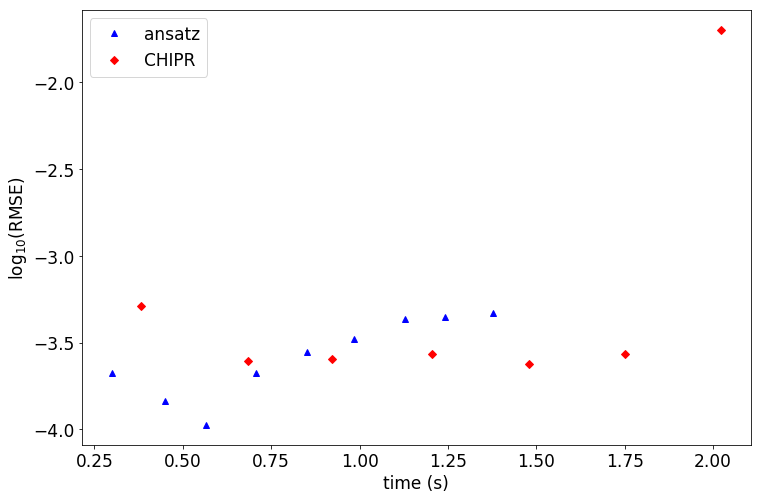

In [64]:
## plot of the table (finding which model is the best)
plt.subplots(figsize=(12, 8))
plt.plot(data["ansatz_t"], np.log10(data["ansatz_acc"]), 'b^')
plt.plot(data["chipr_t"], np.log10(data["chipr_acc"]), 'rD')
plt.xlabel("time (s)"); plt.ylabel("log$_{10}$(RMSE)")
plt.legend(["ansatz", "CHIPR"])
print("==== Optimization stats ====")
print("data: ", list_data[qidxs[idx]]["mol"], list_data[qidxs[idx]]["state"], list_data[qidxs[idx]]["author"],
      len(R),"data points")
print("optimization restarts = ",data["opt_restart"][0])
print("optimization power = ", data["opt_power"][0])
print("delta threshold = ", data["opt_delta"][0])
print("evaluation loops = ",data["eval_loop"][0])
print("evaluation runs = ",data["eval_run"][0])
print("elapsed time = ", data["simulation_time"][0], "s")

In [ ]:
#Notes:
# - plot the data error